# Bank Account Assessment Project Part 4
### Bias-variance trade-off

#### Using gradient descent to minimize the cost function
Finding the best parameters for the function: y = x^2 - 2x

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["figure.dpi"] = 400

def cost_function(x):
    return x * (x - 2)

[-3.  -2.9 -2.8 -2.7 -2.6] ... [4.6 4.7 4.8 4.9 5. ]


Text(0.5, 1.0, 'Error surface')

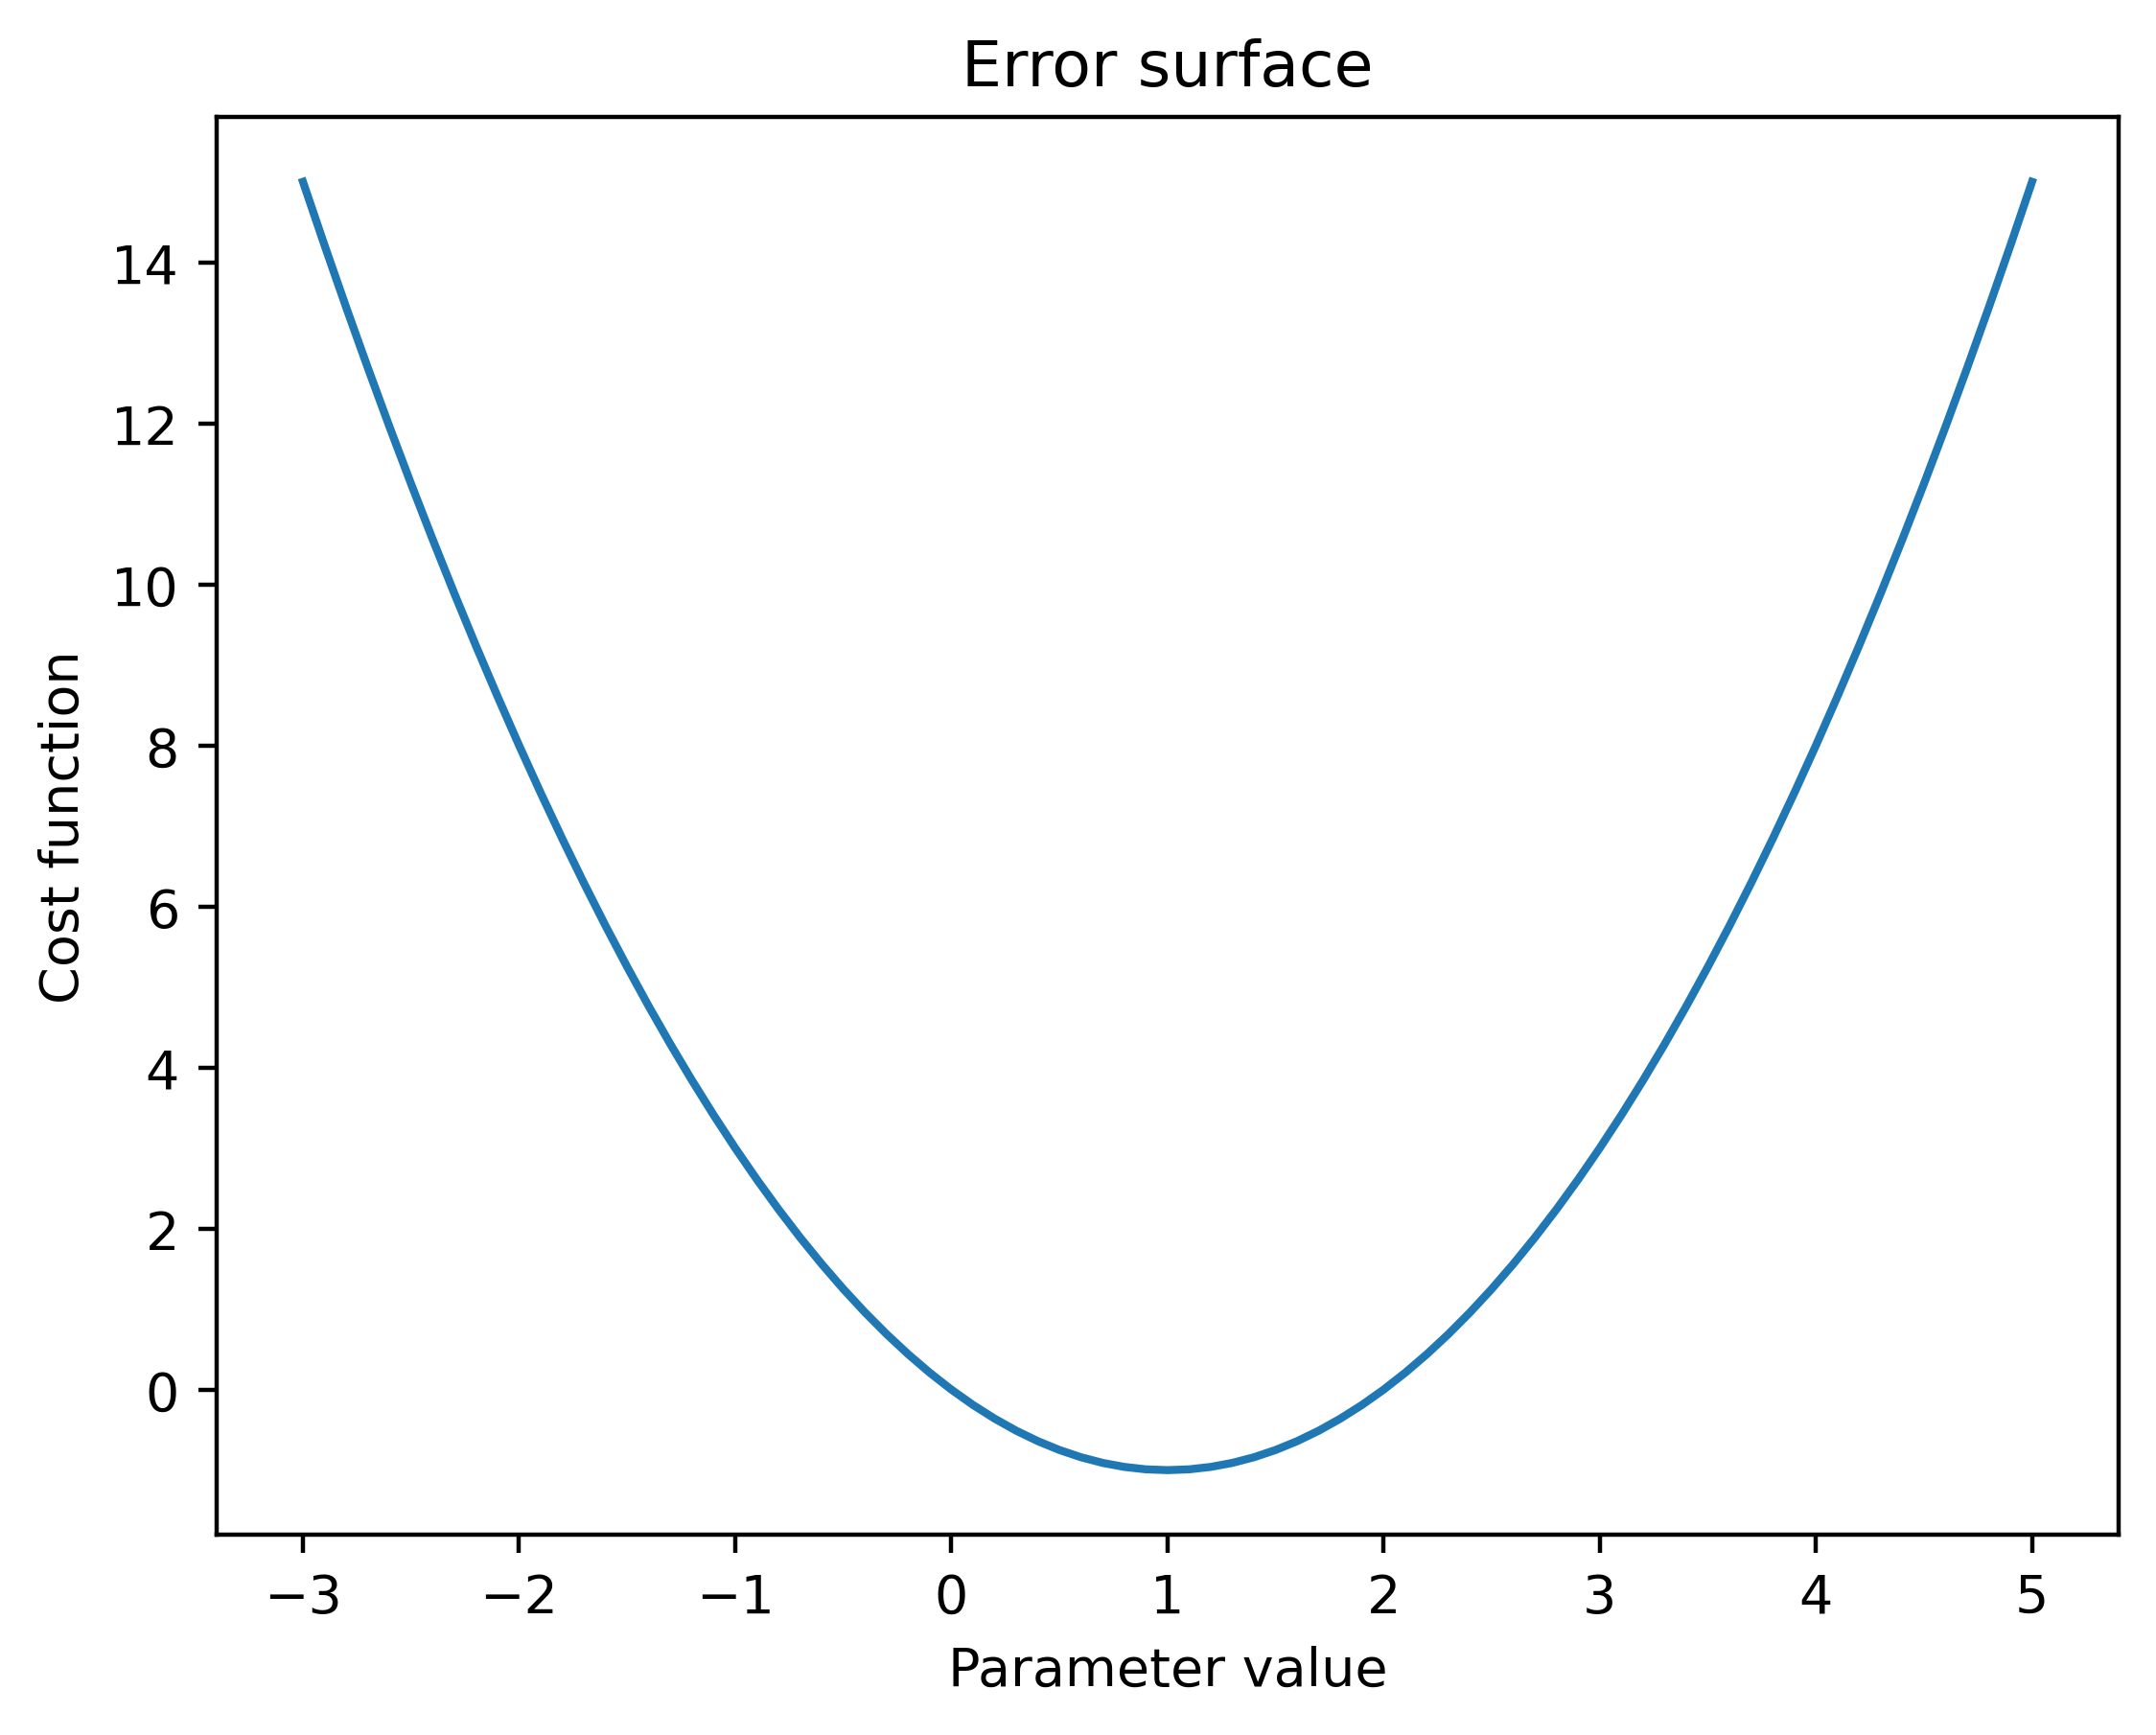

In [24]:
x_poly = np.linspace(-3, 5, 81)
print(x_poly[:5], "...", x_poly[-5:])
y_poly = cost_function(x_poly)

plt.plot(x_poly, y_poly)
plt.xlabel("Parameter value")
plt.ylabel("Cost function")
plt.title("Error surface")

In [25]:
def gradient(x):
    return (2 * x) - 2

x_start = 4.5
learning_rate = 0.75
x_next = x_start - gradient(x_start) * learning_rate
x_next

-0.75

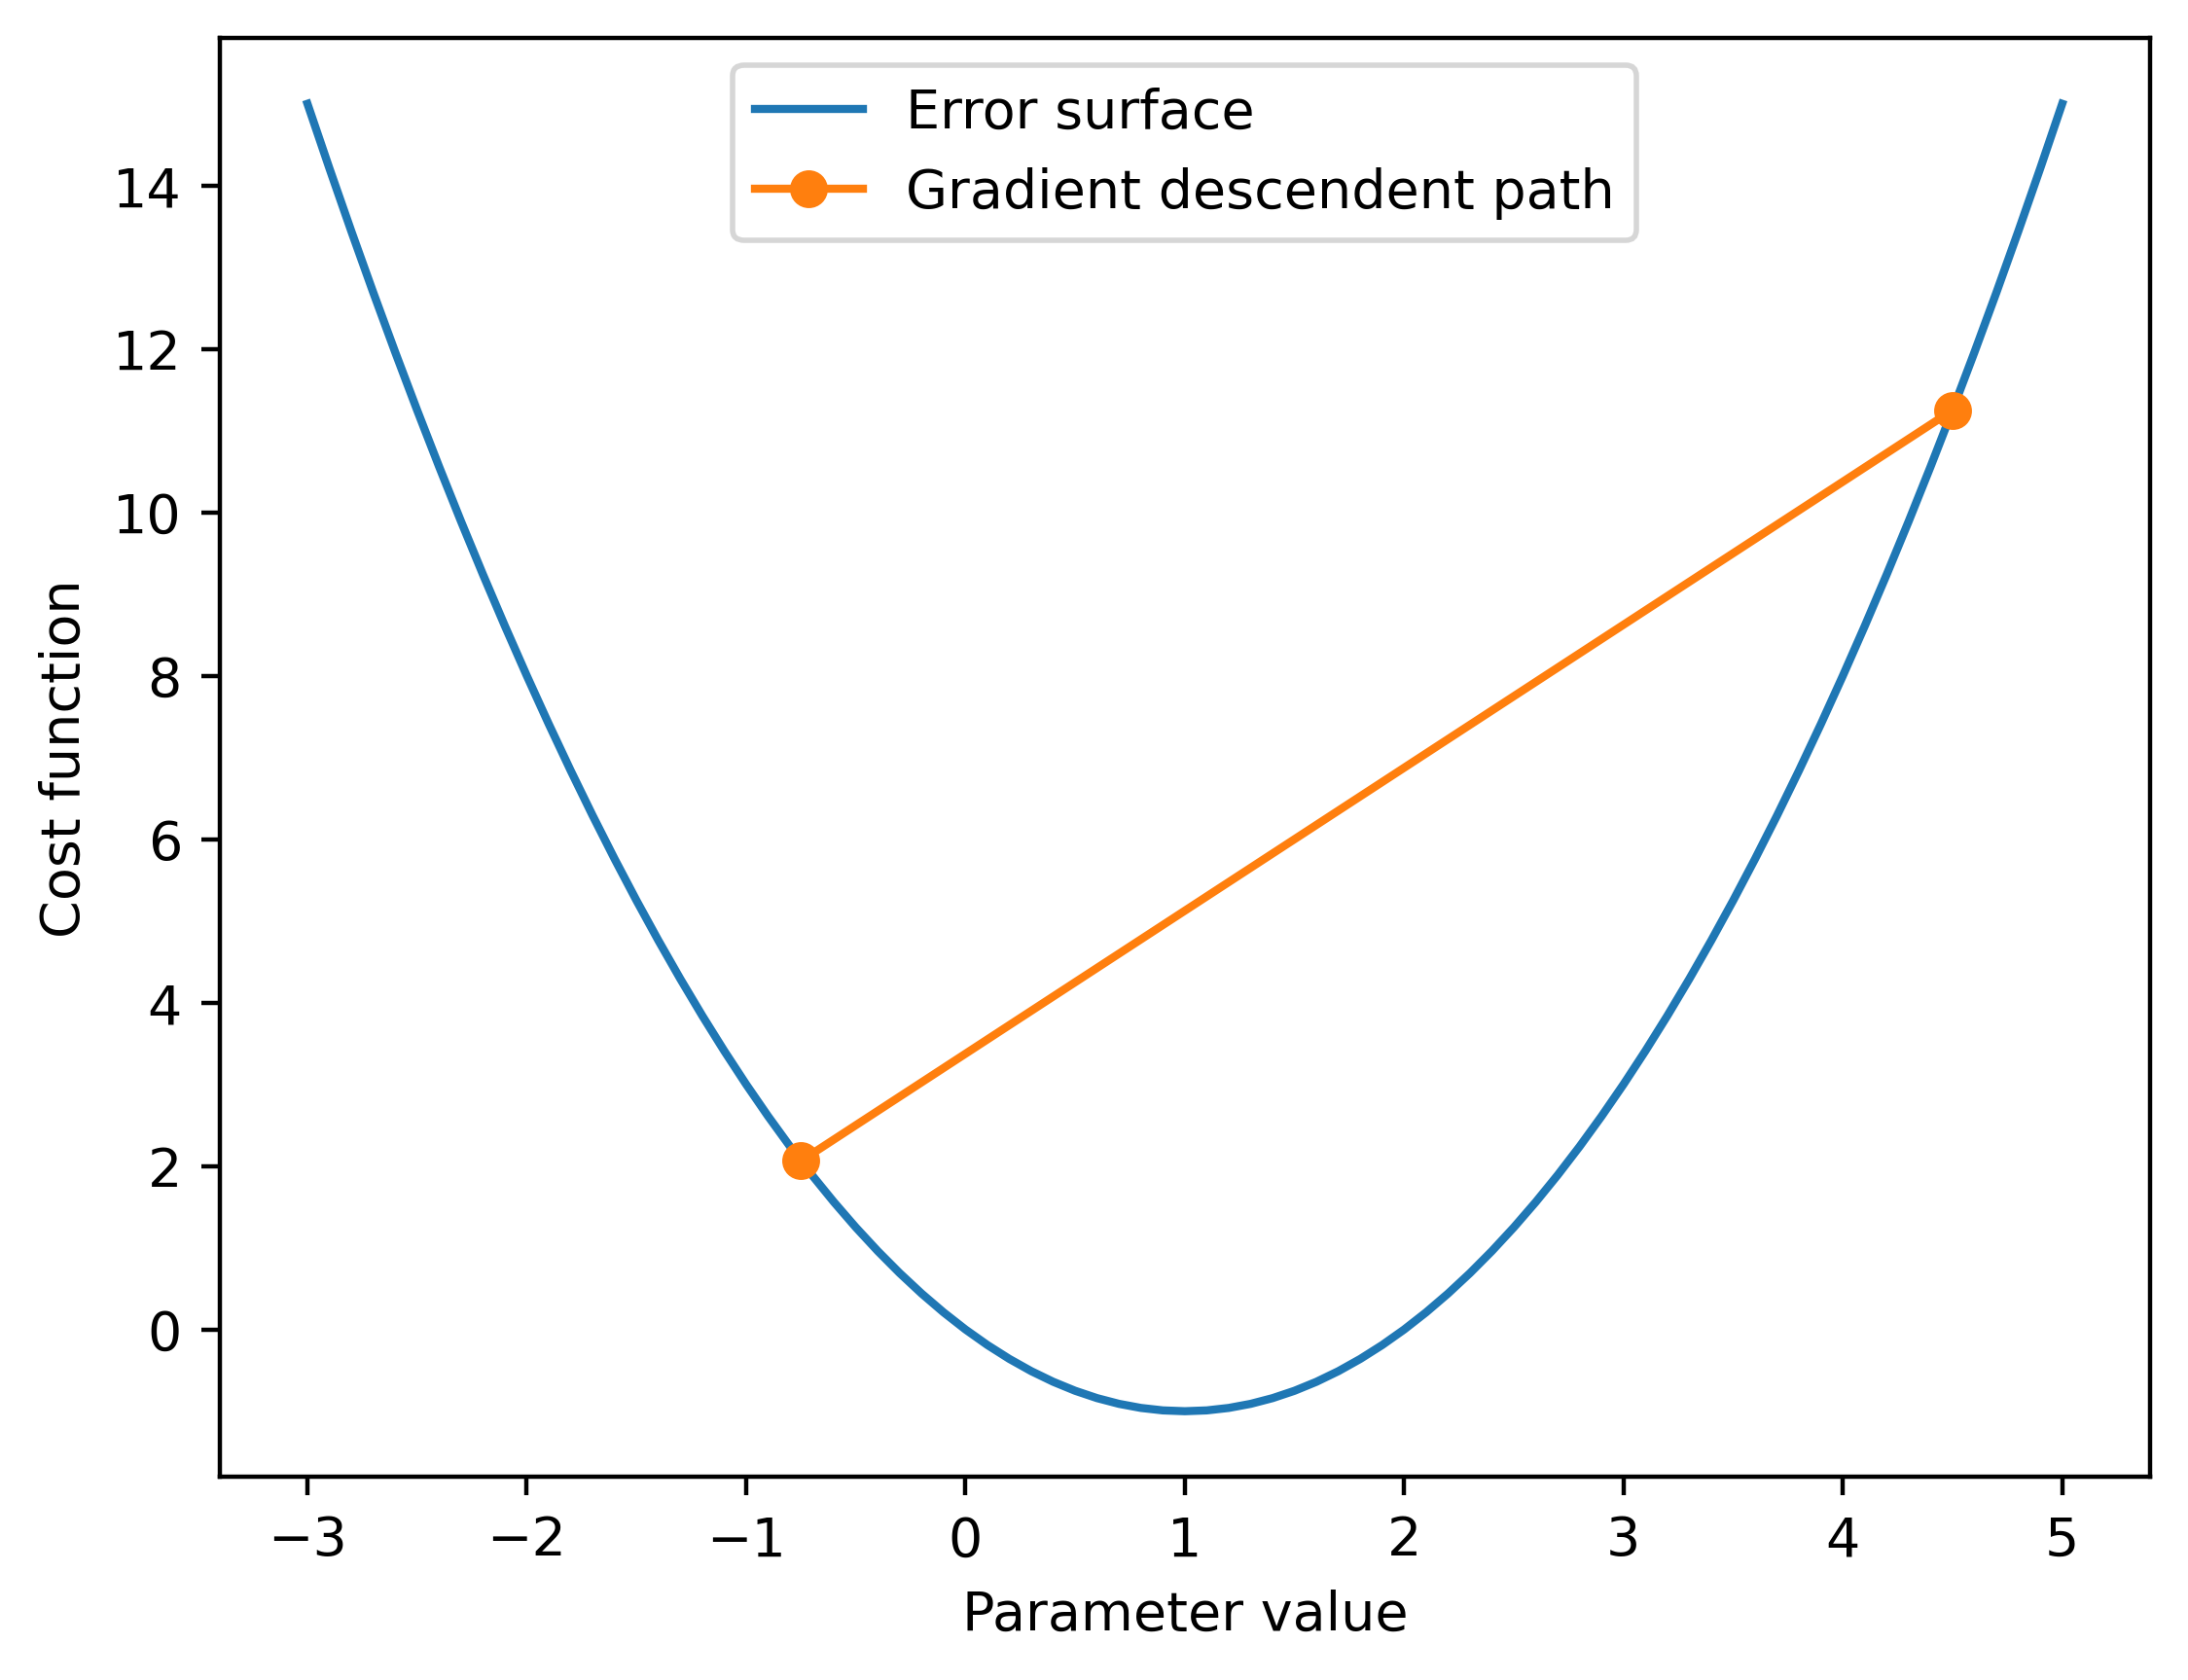

In [26]:
# plot descendent gradient path
plt.plot(x_poly, y_poly)
plt.plot([x_start, x_next], [cost_function(x_start), cost_function(x_next)], "-o")
plt.xlabel("Parameter value")
plt.ylabel("Cost function")
plt.legend(["Error surface", "Gradient descendent path"])

In [27]:
iterations = 15
x_path = np.empty(iterations, )
x_path[0] = x_start

for iteration_count in range(1, iterations):
    derivative = gradient(x_path[iteration_count - 1])
    x_path[iteration_count] = x_path[iteration_count - 1] - (derivative * learning_rate)

x_path

array([ 4.5       , -0.75      ,  1.875     ,  0.5625    ,  1.21875   ,
        0.890625  ,  1.0546875 ,  0.97265625,  1.01367188,  0.99316406,
        1.00341797,  0.99829102,  1.00085449,  0.99957275,  1.00021362])

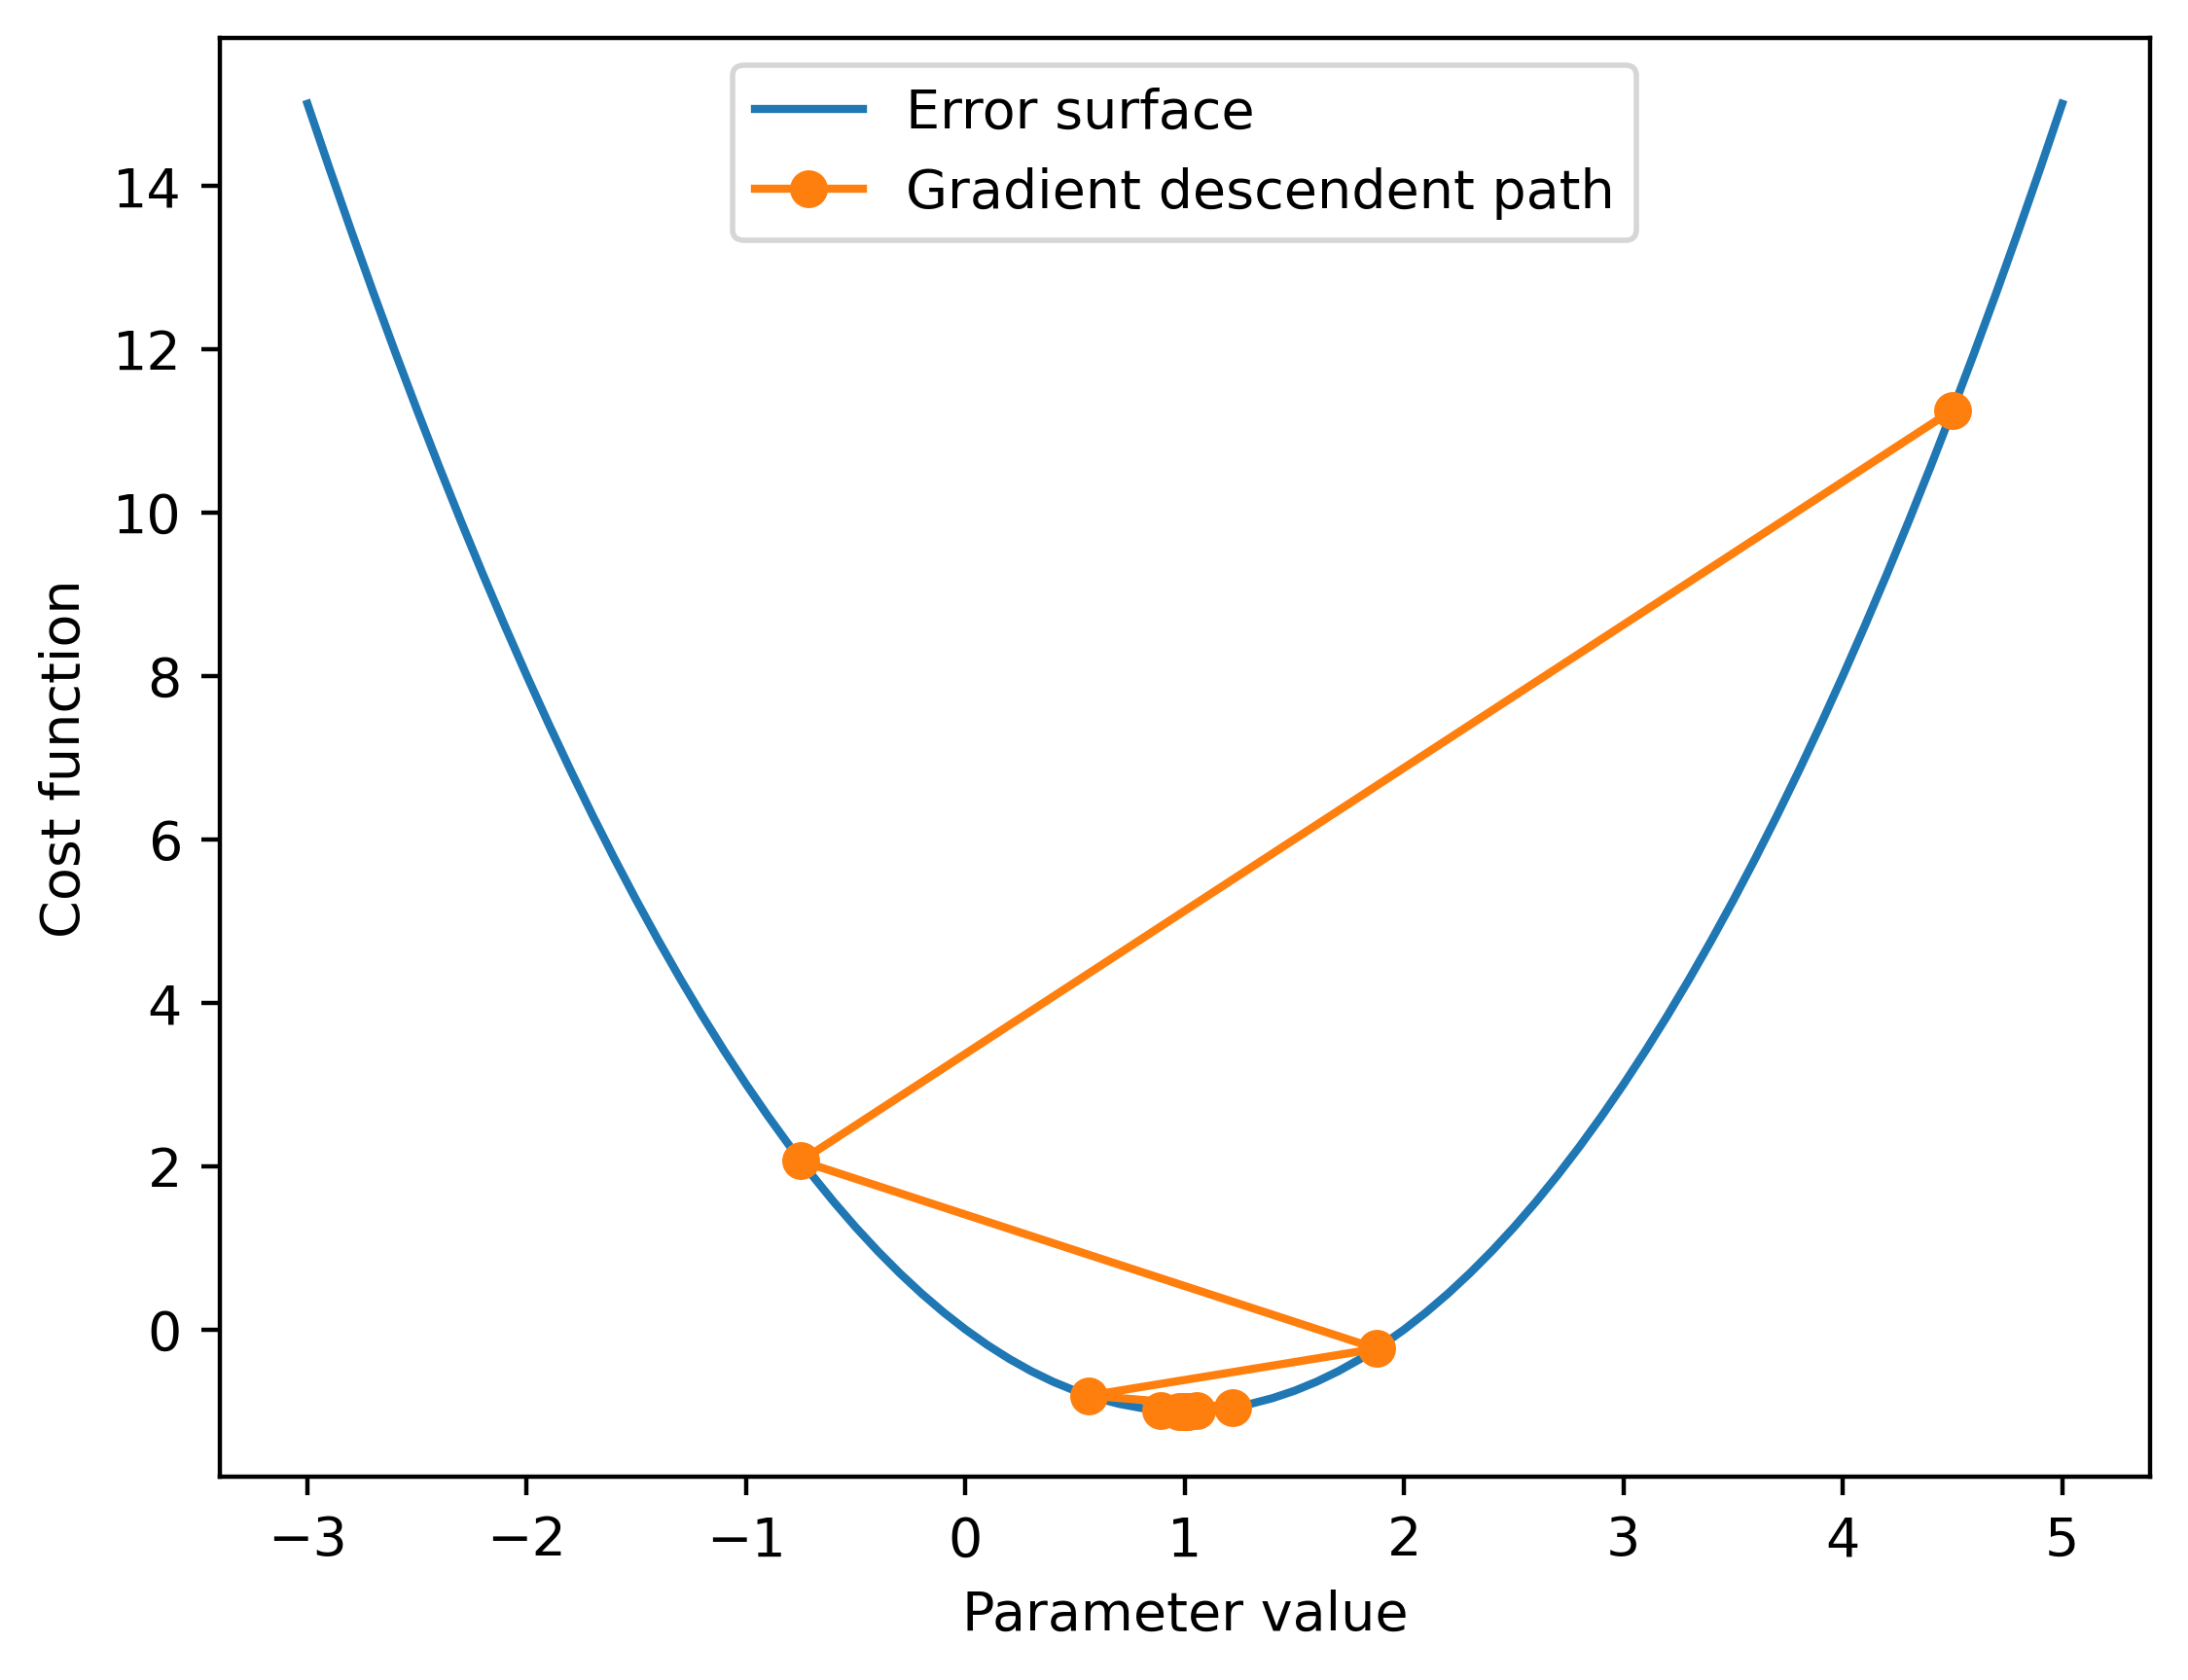

In [28]:
# plot descendent gradient full path
plt.plot(x_poly, y_poly)
plt.plot(x_path, cost_function(x_path), "-o")
plt.xlabel("Parameter value")
plt.ylabel("Cost function")
plt.legend(["Error surface", "Gradient descendent path"])

<Axes: >

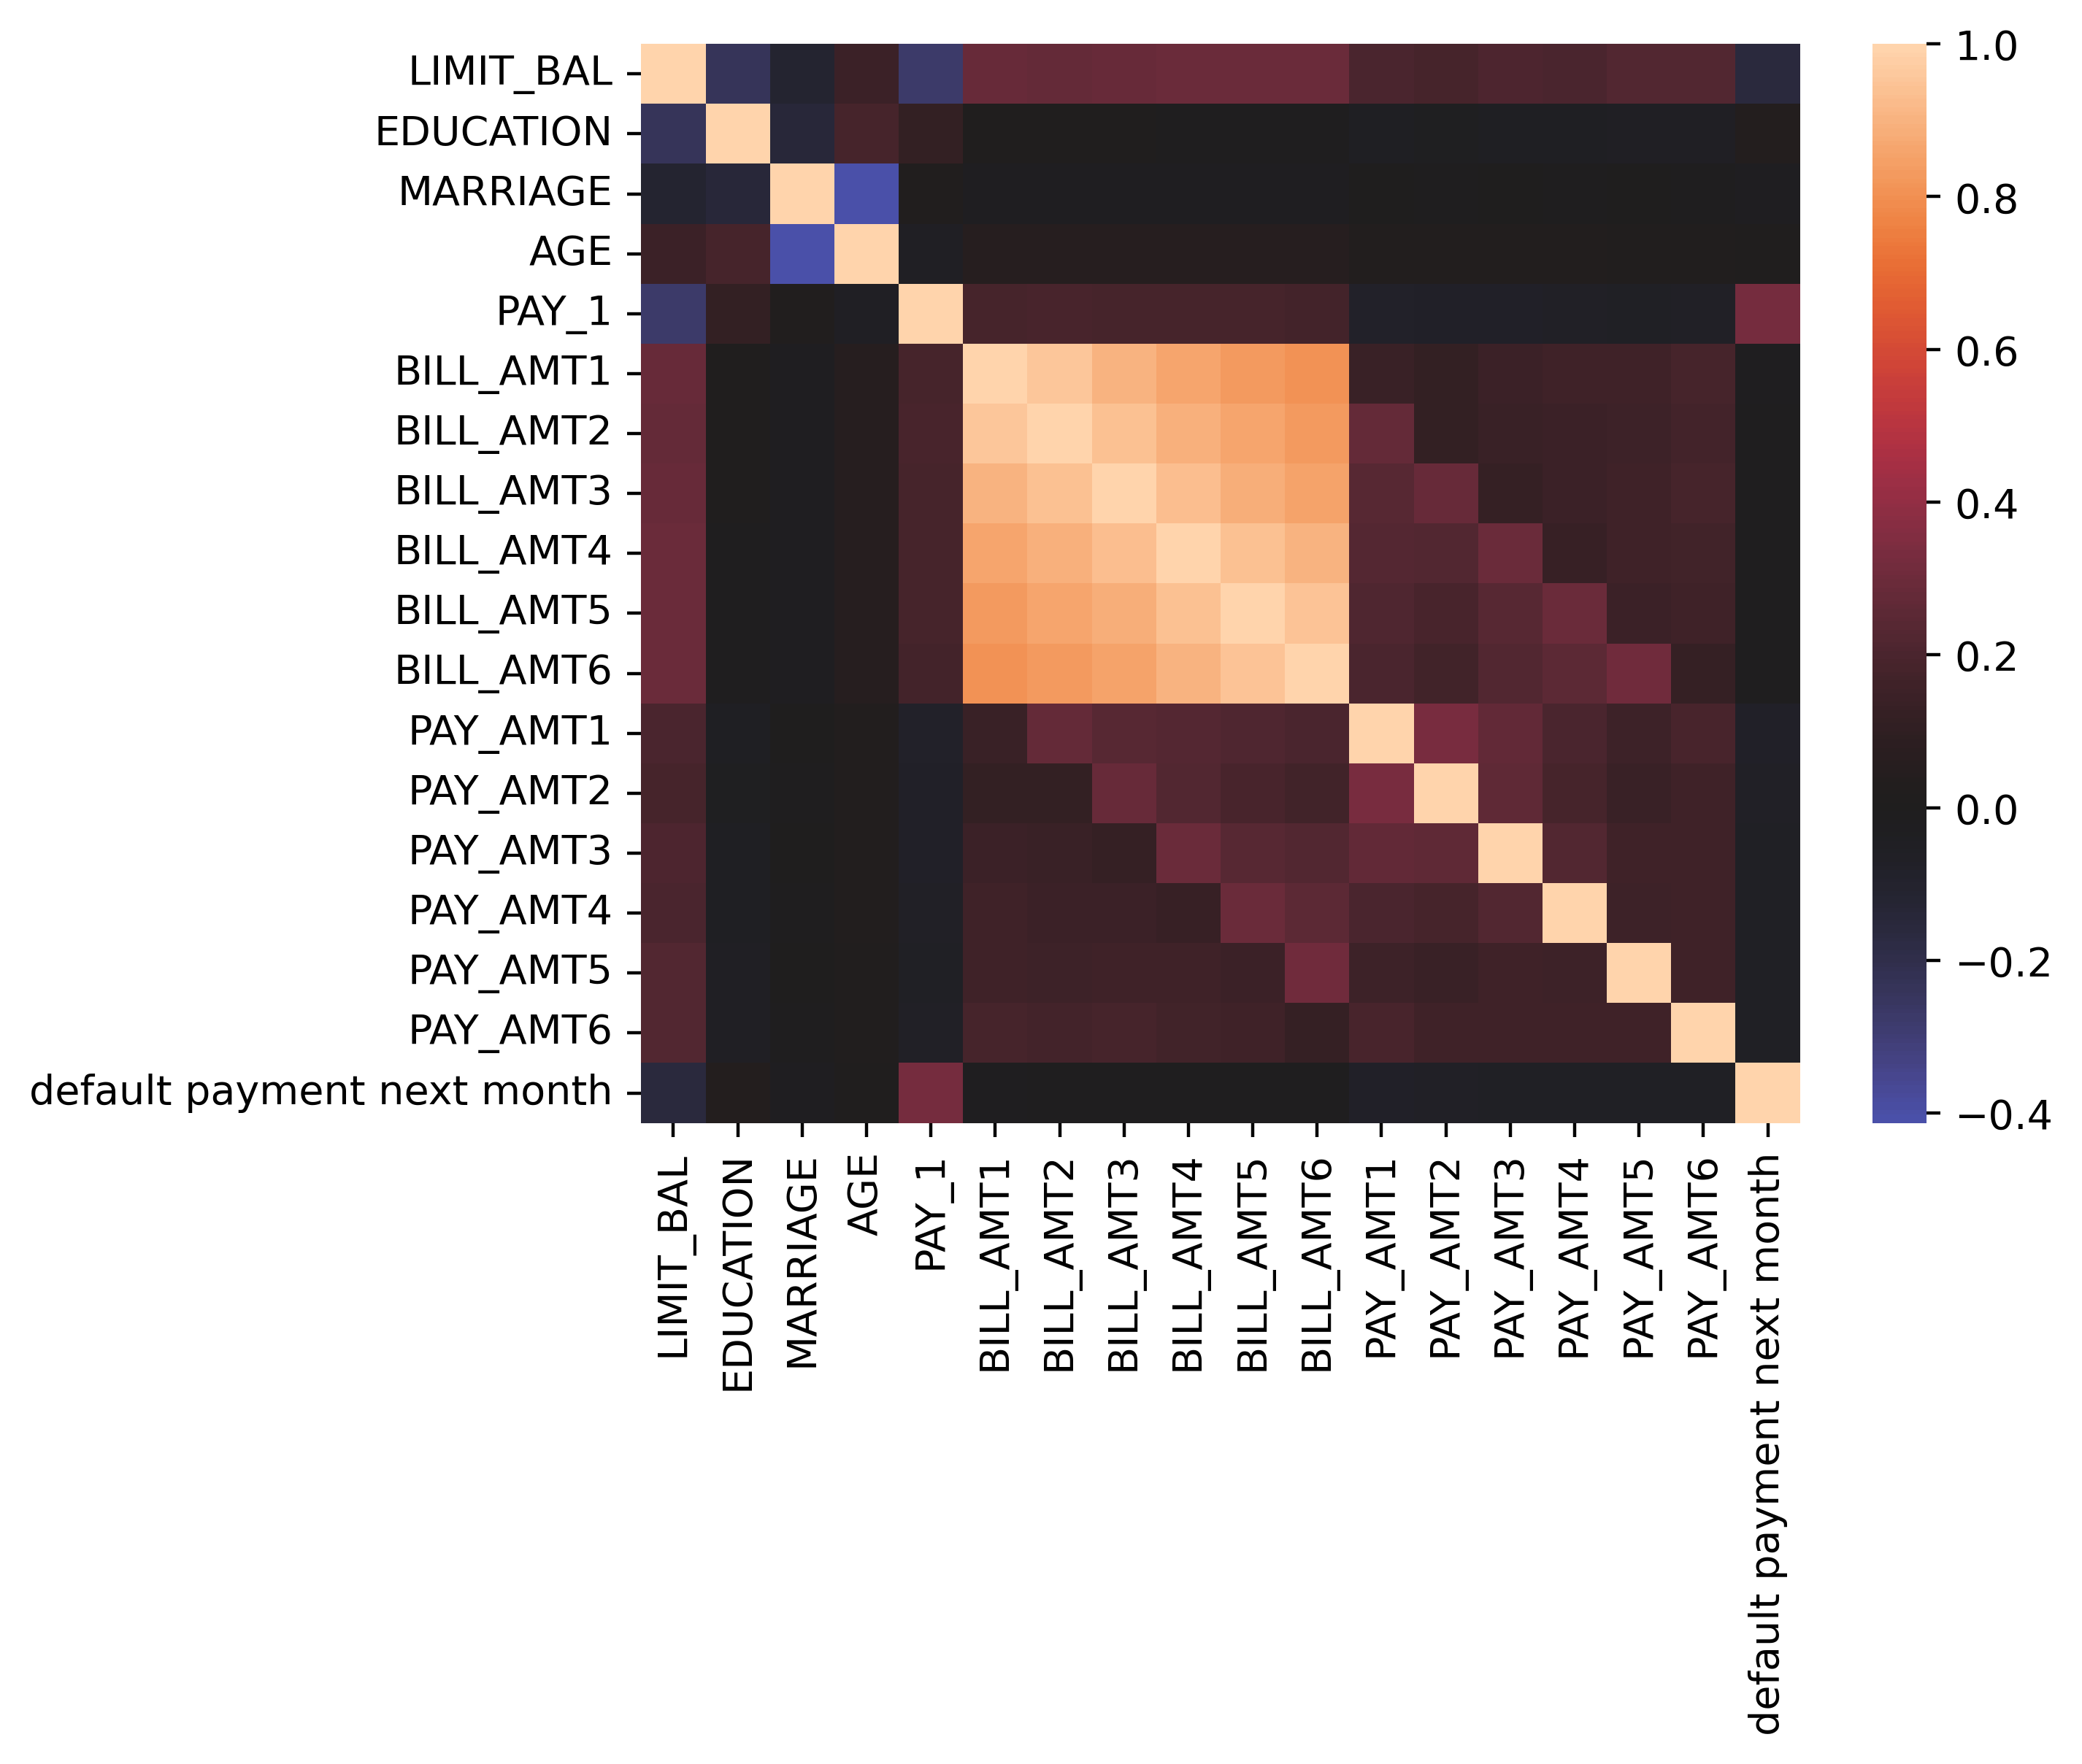

In [29]:
# verify multicollinearity
df = pd.read_csv("Chapter_1_cleaned_data.csv")
features_response = df.columns.tolist()
items_to_remove = ["ID", "SEX", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6", "EDUCATION_CAT",
                   "graduate school", "high school", "none", "others", "university"]

features_response = [item for item in features_response if item not in items_to_remove]
corr = df[features_response].corr()
sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,
           center=0)

In [30]:
# generating and modelling hypothetical data
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [31]:
x_synthetic, y_synthetic =  make_classification(n_samples=1000, n_features=200, n_informative=3,
                            n_redundant=10, n_repeated=0, n_classes=2, n_clusters_per_class=2,
                            weights=None, flip_y=0.01, class_sep=0.8, hypercube=True, shift=0.0,
                            scale=1.0, shuffle=True, random_state=24)
print(x_synthetic.shape, y_synthetic.shape)

(1000, 200) (1000,)


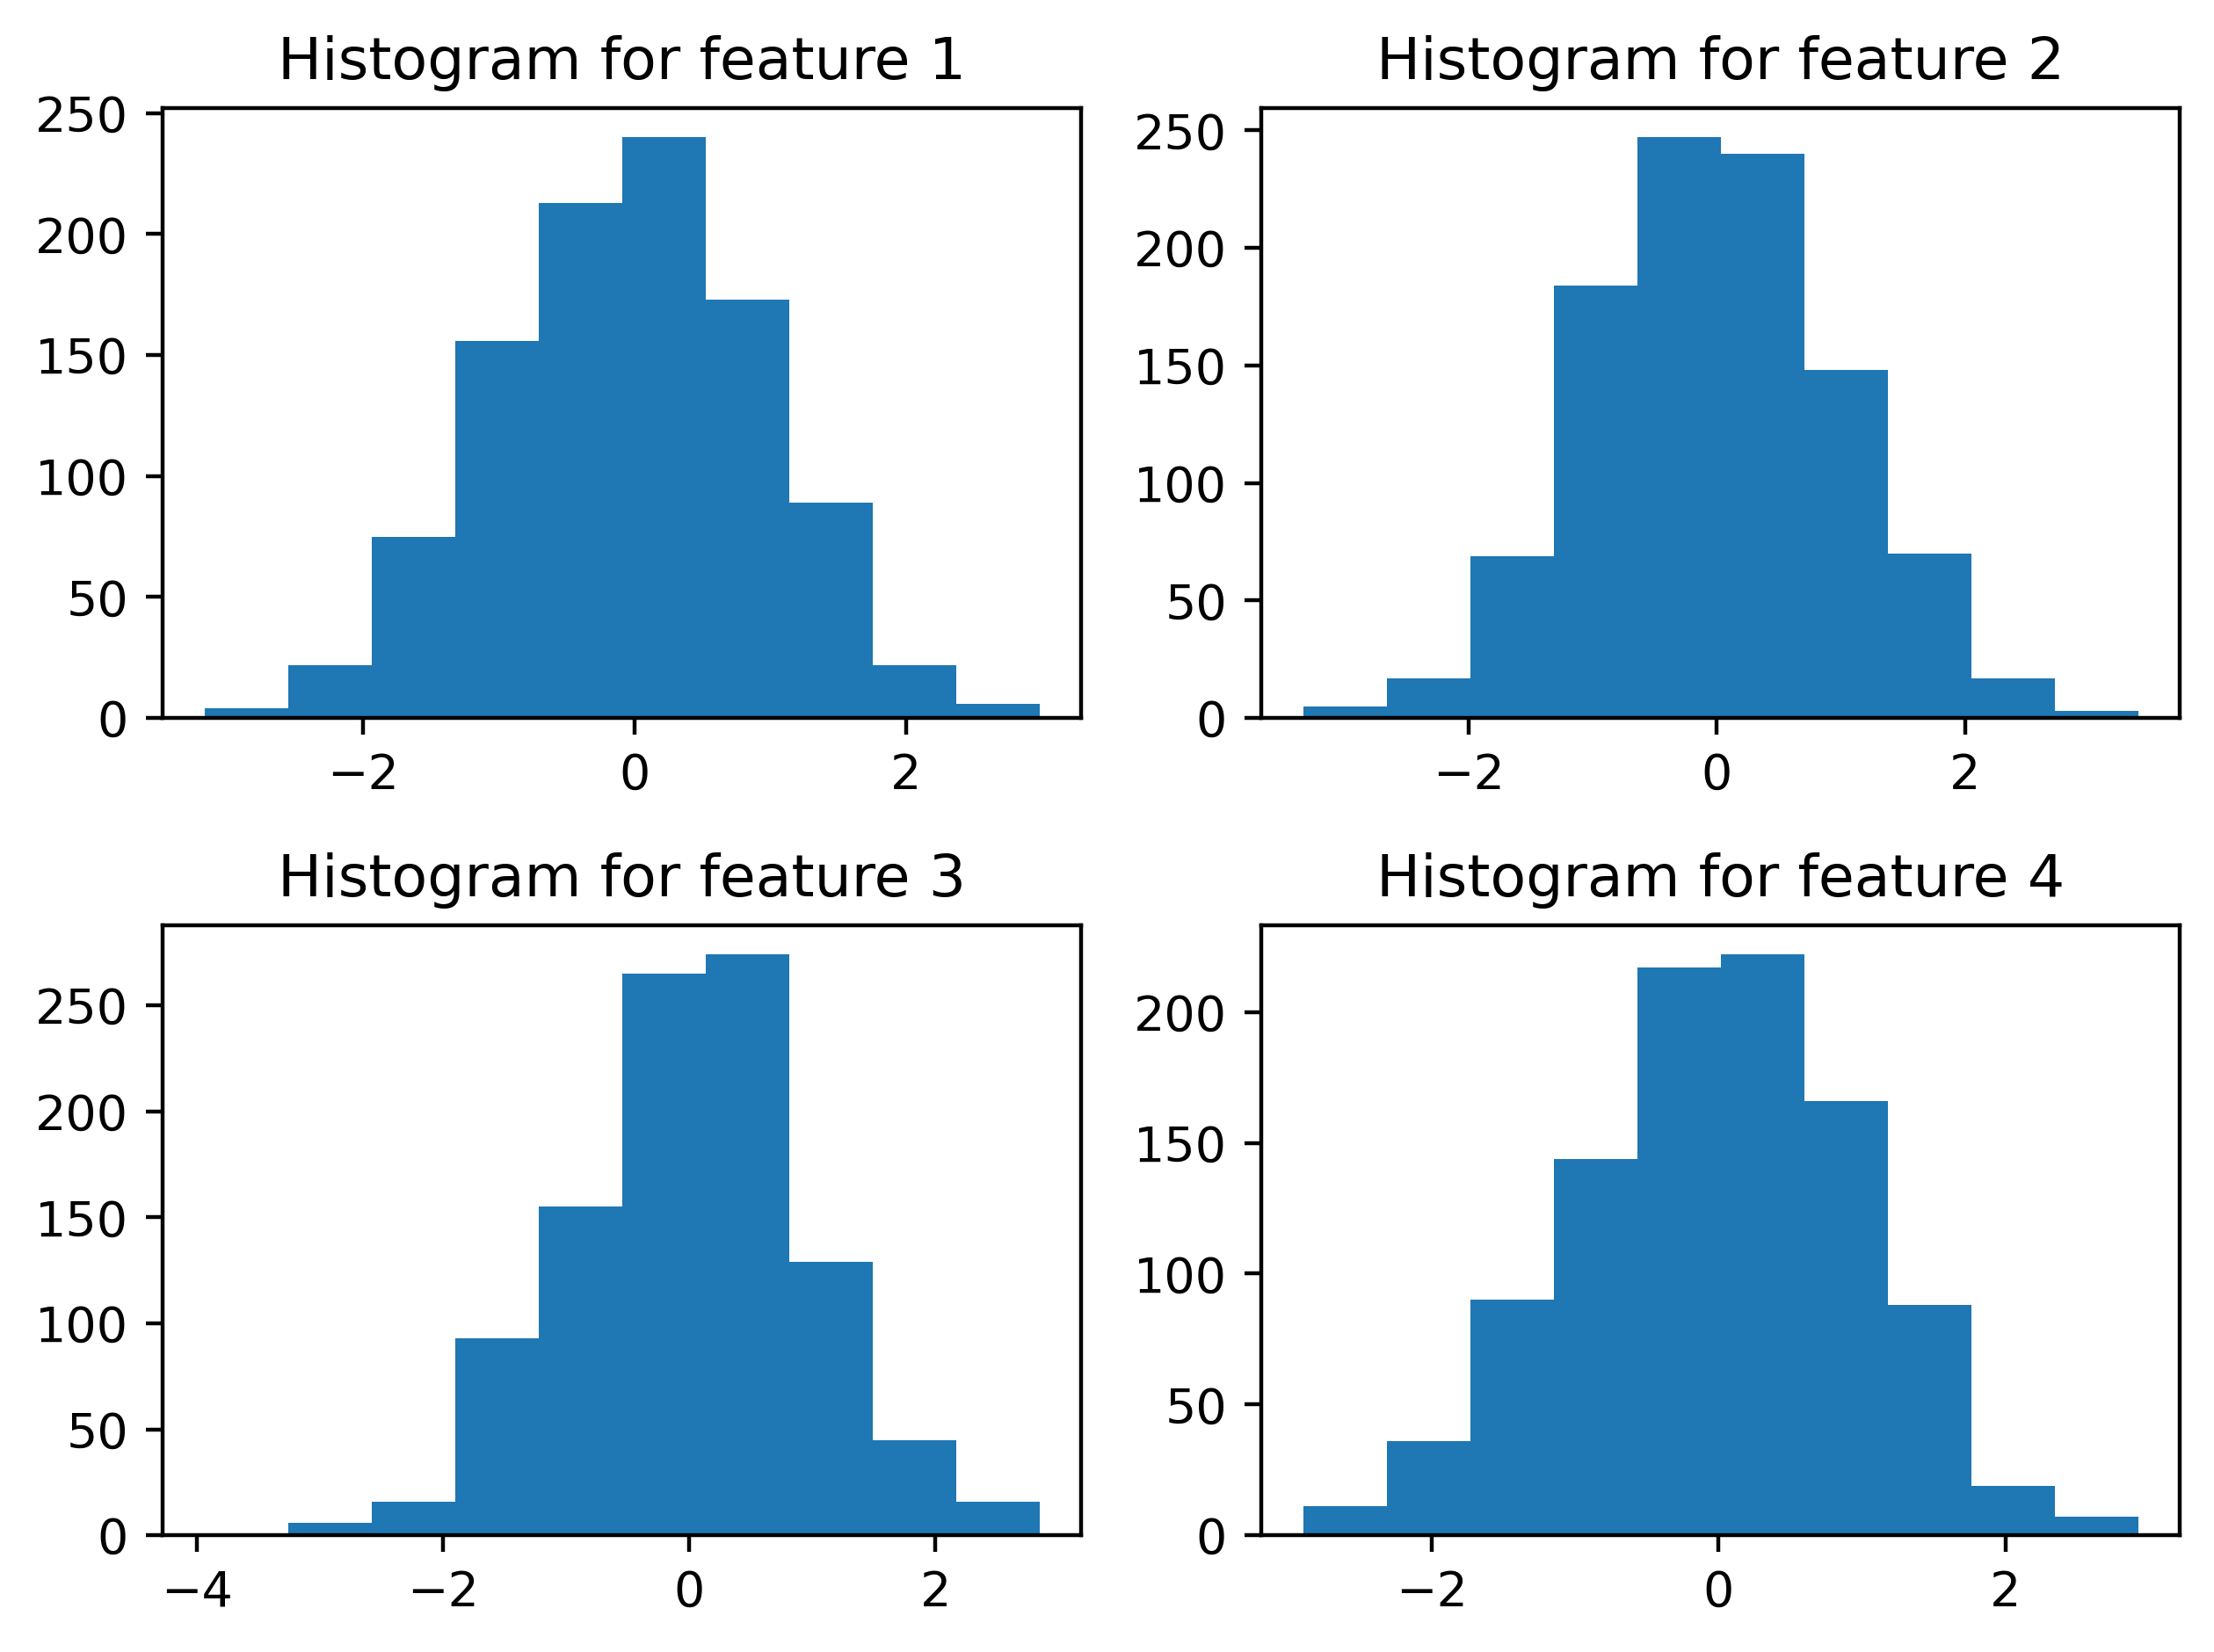

In [32]:
for plot_index in range(4):
    plt.subplot(2, 2, plot_index+1)
    plt.hist(x_synthetic[:, plot_index])
    plt.title(f"Histogram for feature {plot_index+1}")
plt.tight_layout()

In [33]:
x_syn_train, x_syn_test, y_syn_train, y_syn_test = train_test_split(
        x_synthetic, y_synthetic,
        test_size=0.2, random_state=24)

# 'l1' stands for LASSO regularization
lr_syn = LogisticRegression(solver='liblinear', penalty='l1', C=1000, random_state=1)
lr_syn.fit(x_syn_train, y_syn_train)

LogisticRegression(C=1000, penalty='l1', random_state=1, solver='liblinear')

In [34]:
# predict train data
y_syn_train_predict_proba = lr_syn.predict_proba(x_syn_train)
roc_auc_score(y_syn_train, y_syn_train_predict_proba[:, 1])

0.9420000000000001

In [35]:
# predict test data
y_syn_test_predict_proba = lr_syn.predict_proba(x_syn_test)
roc_auc_score(y_syn_test, y_syn_test_predict_proba[:, 1])

0.8075807580758075

### It can be seen that the model is overfitted

Now, reduce overfitting using cross validation.

In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

n_folds = 4

In [37]:
def plot_kfolds(k_folds_iterator):
    # define a colormap
    cmap = plt.cm.get_cmap('PuOr')
    
    fold_counter = 0
    for train_index, test_index in k_folds_iterator.split(x_syn_train, y_syn_train):

        #Axis to hold the plot of this fold
        ax = plt.subplot(n_folds,1,fold_counter+1)

        #Background rectangle representing all samples
        n_train_samples = len(y_syn_train)
        rect = mpl.patches.Rectangle(xy=(0,0), width=n_train_samples, height=1)
        ax.add_patch(rect)

        #Plot each testing sample from this fold as a vertical line
        for this_text_ix in test_index:
            ax.plot([this_text_ix, this_text_ix], [0, 1], color=cmap(1),
                    linewidth=0.75)

        #Plot formatting
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(0, n_train_samples)
        ax.set_ylim(0,1)
        
        #Subplot titles
        if fold_counter == 0:
            ax.text(0.26, 1.2, 'Training data,',
                    transform=ax.transAxes, backgroundcolor = cmap(0))
            ax.text(0.45, 1.2, 'testing data:',
                    transform=ax.transAxes, backgroundcolor = cmap(190))
            ax.text(0.62, 1.2, 'fold {}'.format(fold_counter+1), transform=ax.transAxes)
        else:
            ax.text(0.45, 1.2, 'Fold {}'.format(fold_counter+1), transform=ax.transAxes)

        fold_counter += 1

    plt.tight_layout()

C:\Users\User\AppData\Local\Temp\ipykernel_10404\2197818000.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('PuOr')


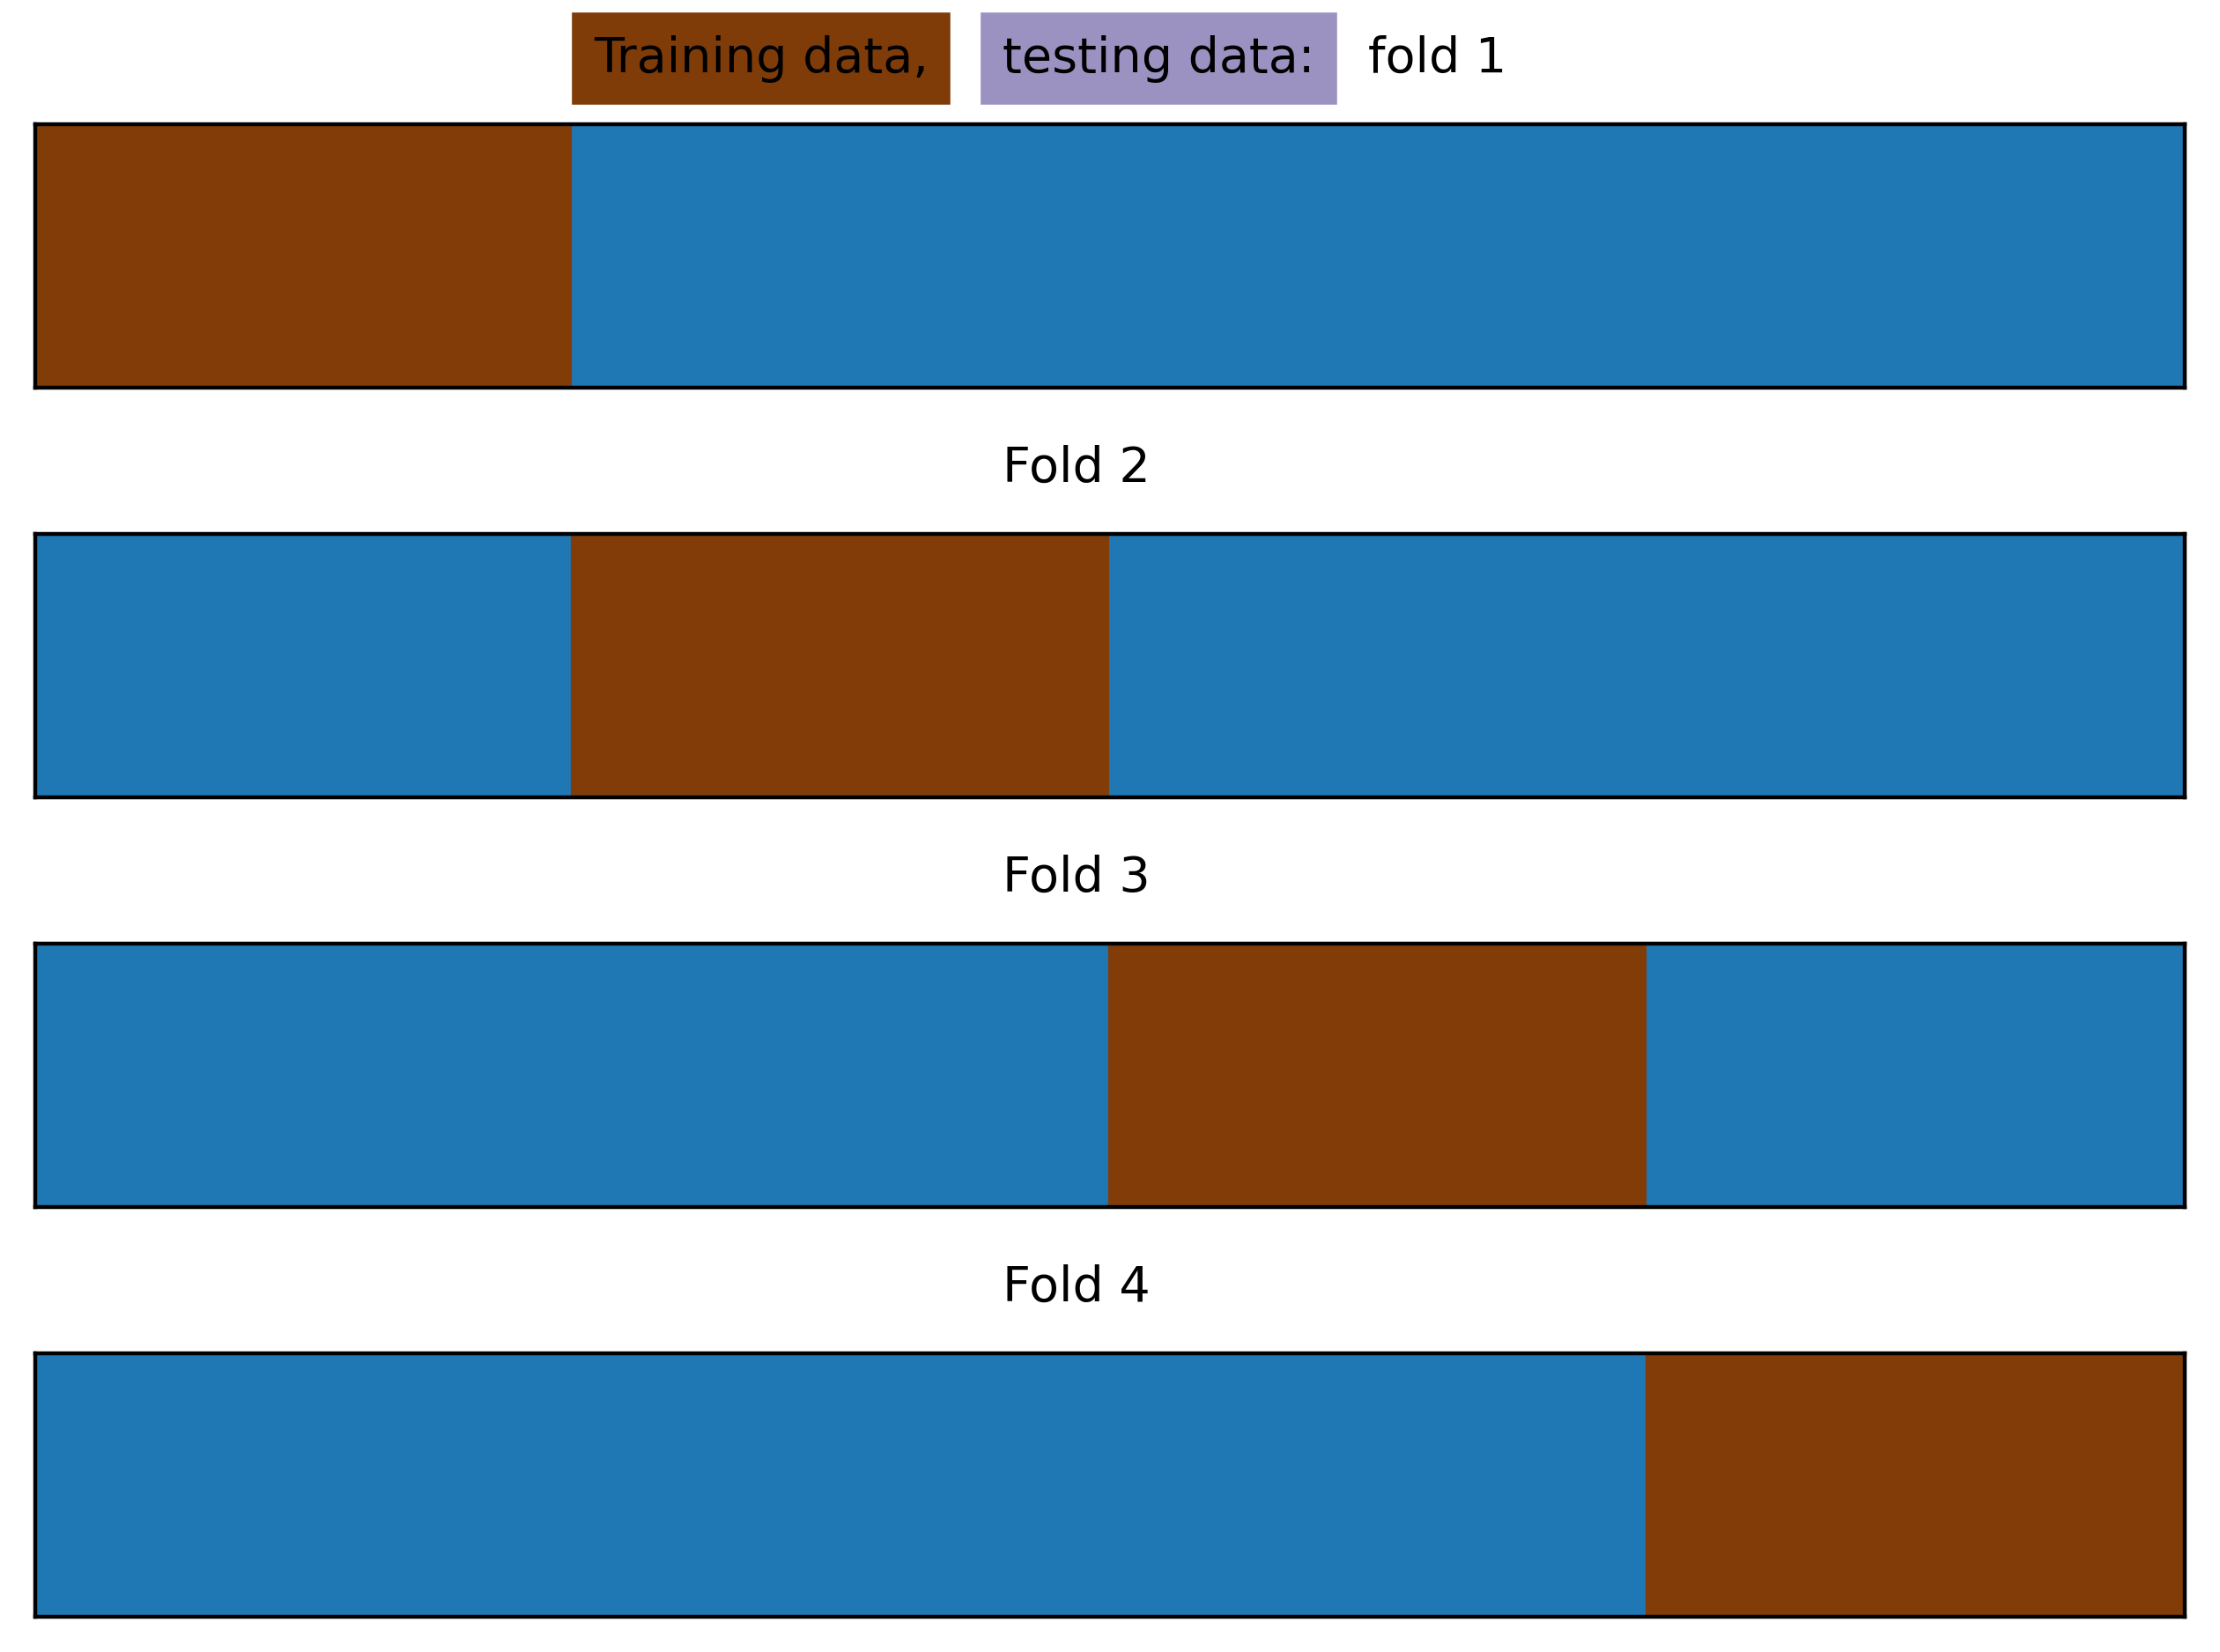

In [38]:
k_folds = KFold(n_splits=n_folds, shuffle=False)
plot_kfolds(k_folds)

StratifiedKFold(n_splits=4, random_state=1, shuffle=True)


C:\Users\User\AppData\Local\Temp\ipykernel_10404\2197818000.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('PuOr')


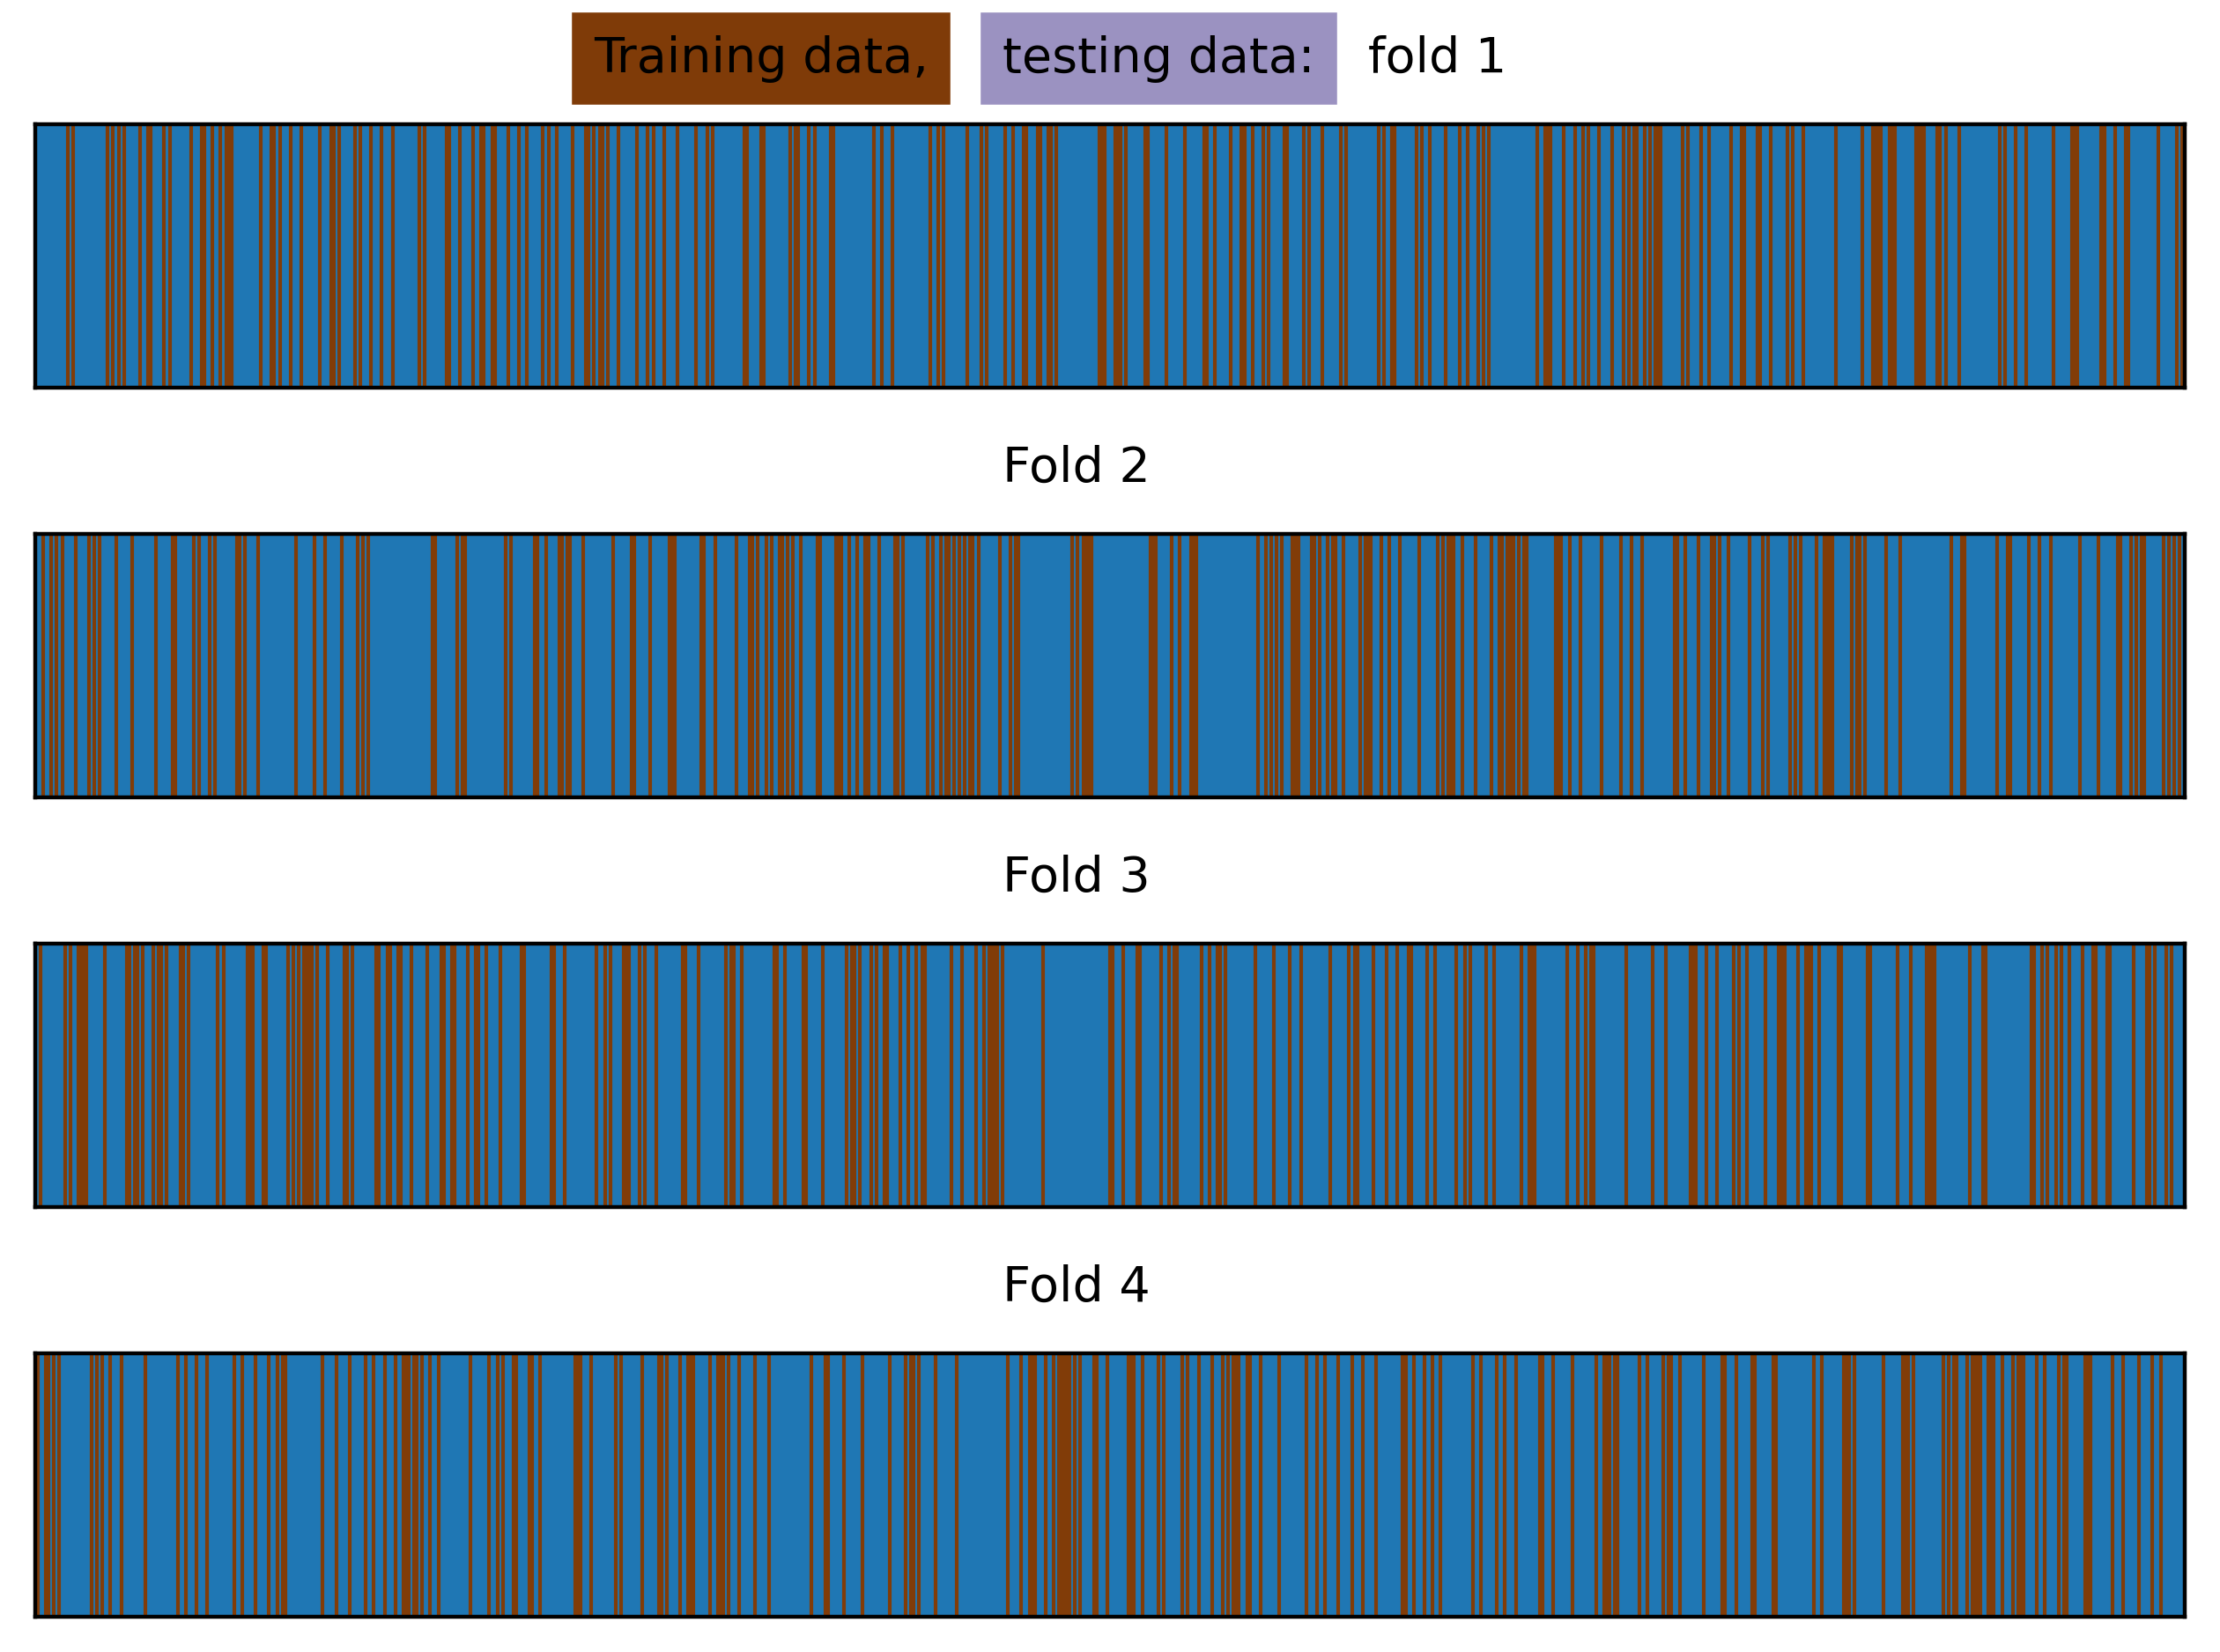

In [39]:
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)
print(k_folds)
plot_kfolds(k_folds)

In [51]:
# c is the hyperparameter
c_val_exponents = np.linspace(3, -3, 13)
c_val_exponents

array([ 3. ,  2.5,  2. ,  1.5,  1. ,  0.5,  0. , -0.5, -1. , -1.5, -2. ,
       -2.5, -3. ])

In [52]:
c_vals = 10.0 ** c_val_exponents
c_vals

array([1.00000000e+03, 3.16227766e+02, 1.00000000e+02, 3.16227766e+01,
       1.00000000e+01, 3.16227766e+00, 1.00000000e+00, 3.16227766e-01,
       1.00000000e-01, 3.16227766e-02, 1.00000000e-02, 3.16227766e-03,
       1.00000000e-03])

In [53]:
from sklearn.metrics import roc_curve

In [54]:
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)
def cross_val_c_search(k_folds, C_vals, model, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)

    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        model.C = C_vals[c_val_counter]
        #Count folds for each value of C
        fold_counter = 0
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            #Fit the model on the training data
            model.fit(X_cv_train, y_cv_train)

            #Get the training ROC AUC
            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            #Get the testing ROC AUC
            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            #Increment the fold counter
            fold_counter += 1

        #Indicate progress
        print('Done with C = {}'.format(lr_syn.C))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [55]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_c_search(k_folds, c_vals, lr_syn, x_syn_train, y_syn_train)

Done with C = 1000.0
Done with C = 316.22776601683796
Done with C = 100.0
Done with C = 31.622776601683793
Done with C = 10.0
Done with C = 3.1622776601683795
Done with C = 1.0
Done with C = 0.31622776601683794
Done with C = 0.1
Done with C = 0.03162277660168379
Done with C = 0.01
Done with C = 0.0031622776601683794
Done with C = 0.001


C:\Users\User\AppData\Local\Temp\ipykernel_10404\1928341021.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma')


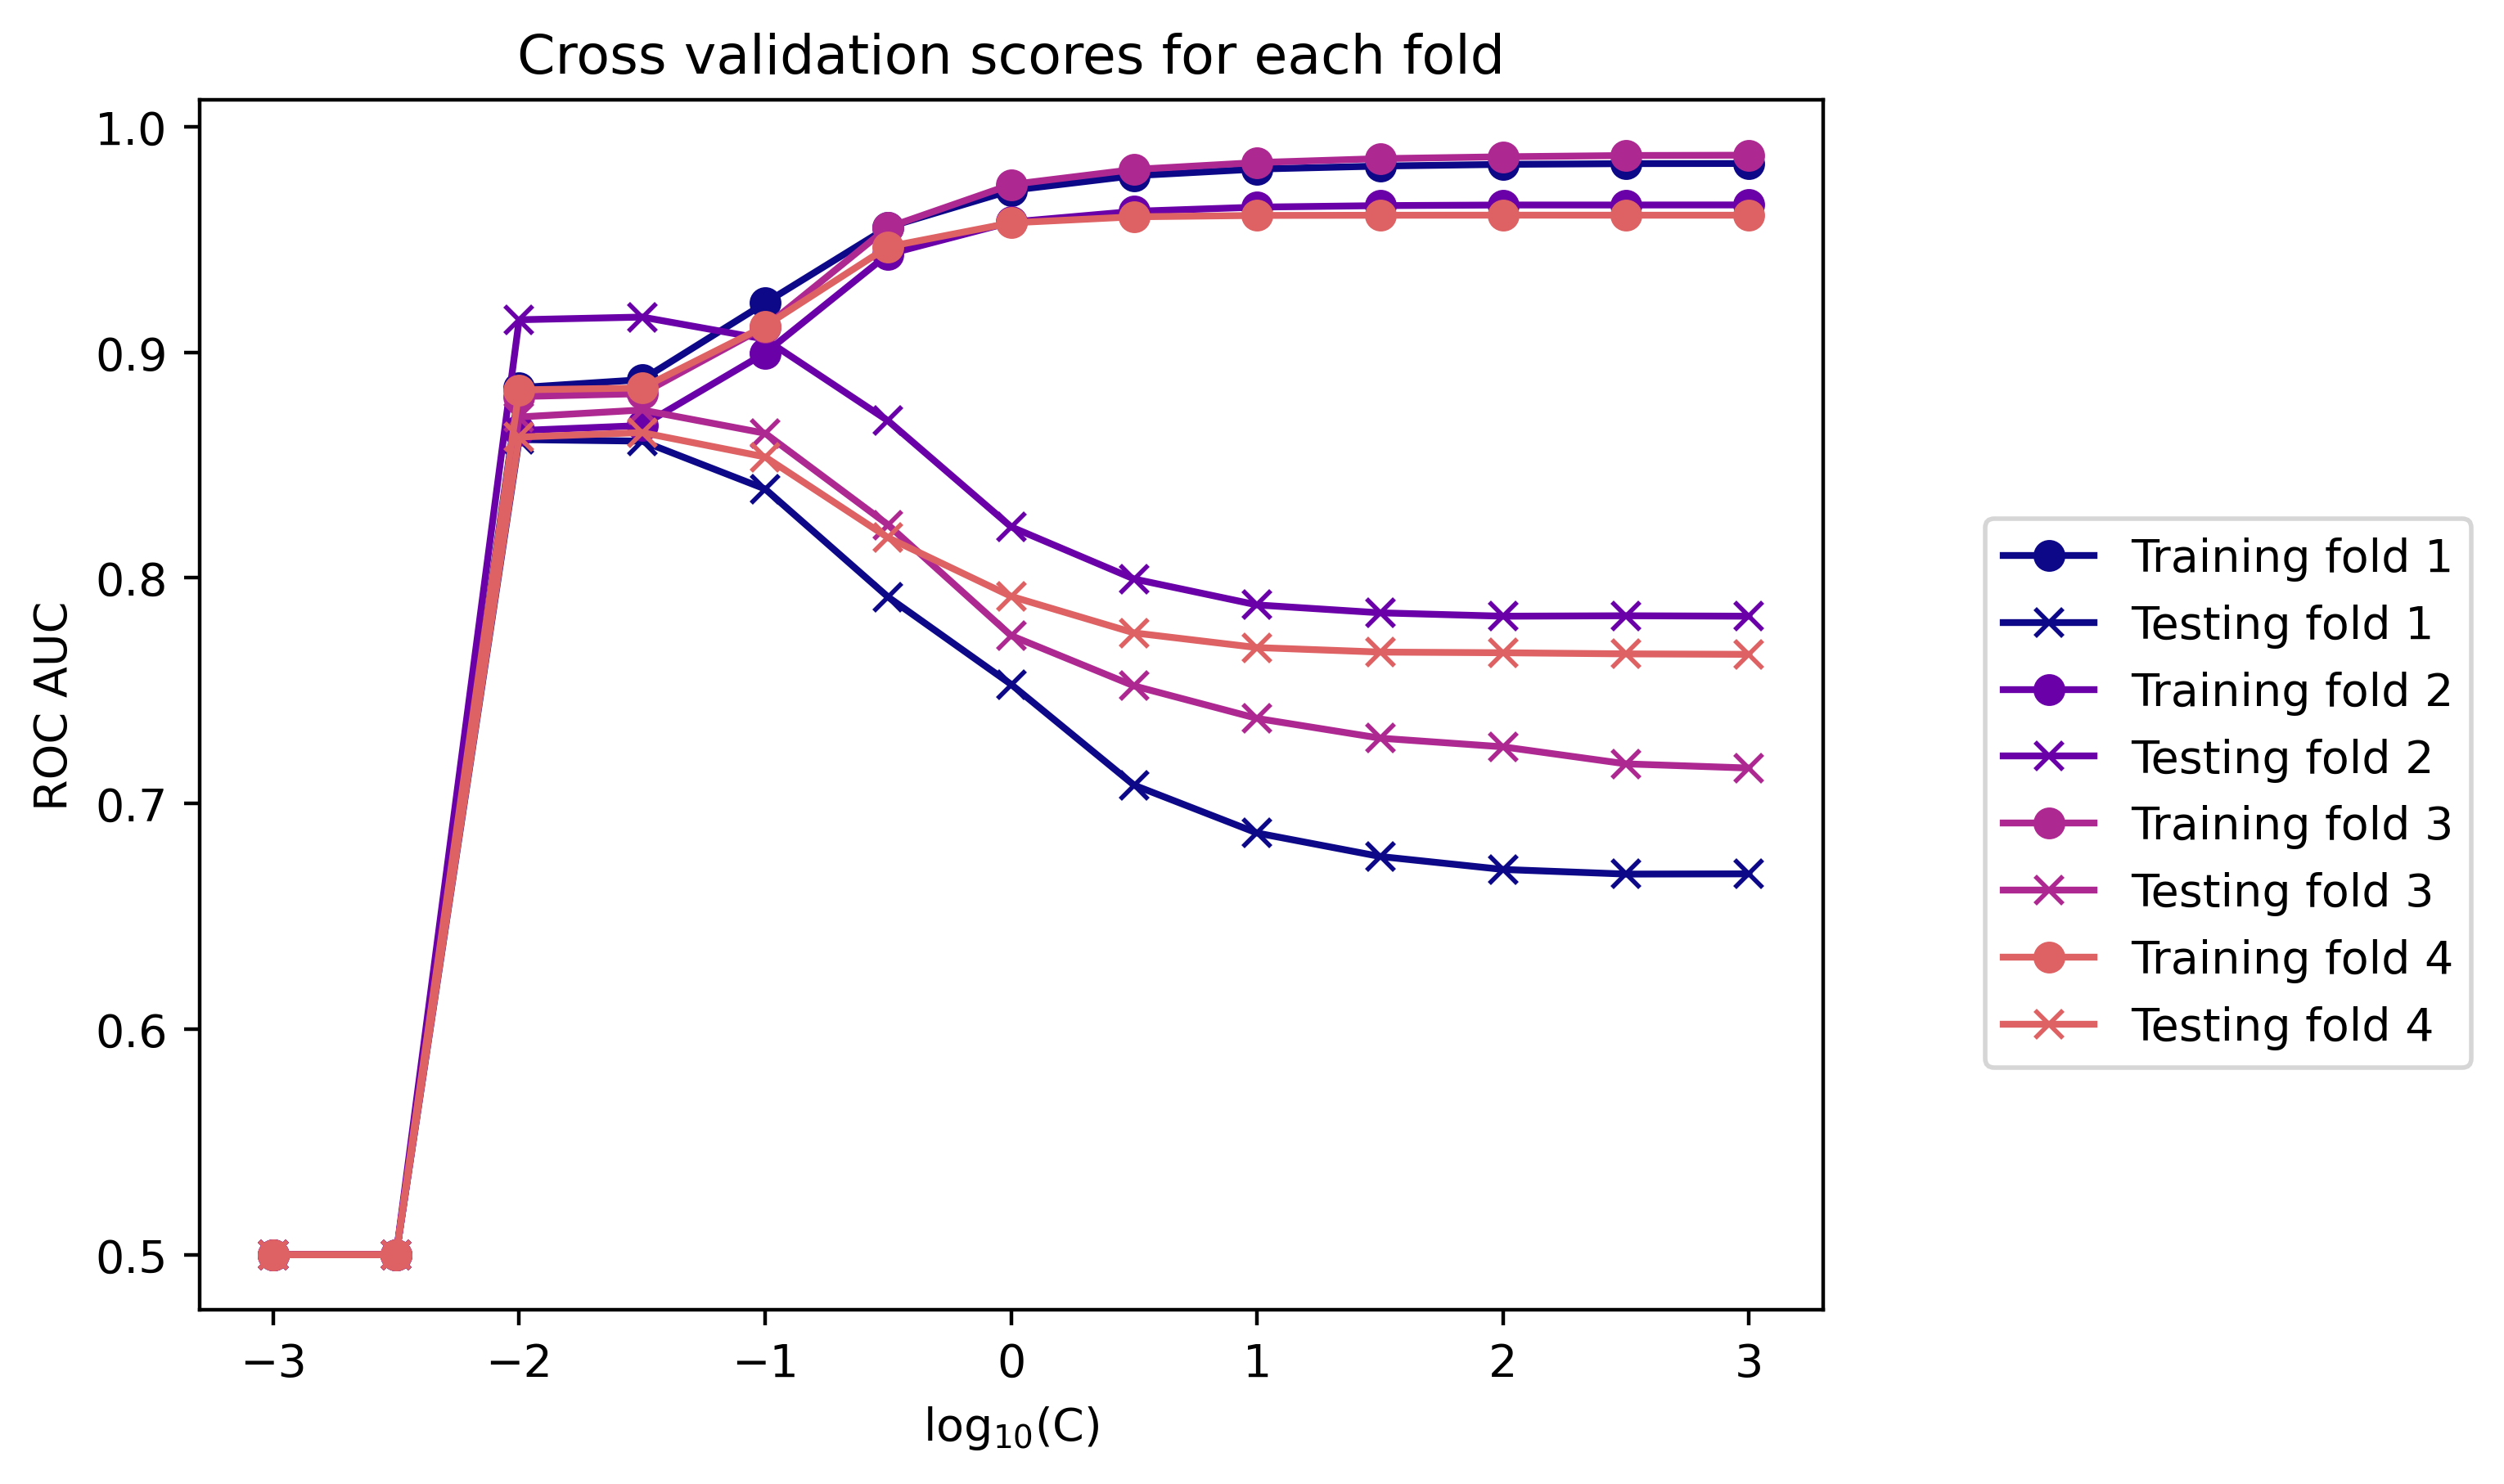

In [56]:
cmap = plt.cm.get_cmap('plasma')

for this_fold in range(n_folds):
    plt.plot(c_val_exponents, cv_train_roc_auc[this_fold], "-o",
            color=cmap(this_fold*50), label="Training fold {}".format(this_fold+1))
    plt.plot(c_val_exponents, cv_test_roc_auc[this_fold], "-x",
            color=cmap(this_fold*50), label="Testing fold {}".format(this_fold+1))

    plt.ylabel("ROC AUC")
    plt.xlabel("log$_{10}$(C)")
    plt.legend(loc=[1.1, 0.2])
    plt.title("Cross validation scores for each fold")

Text(0.5, 1.0, 'Cross validation scores averaged over all folds')

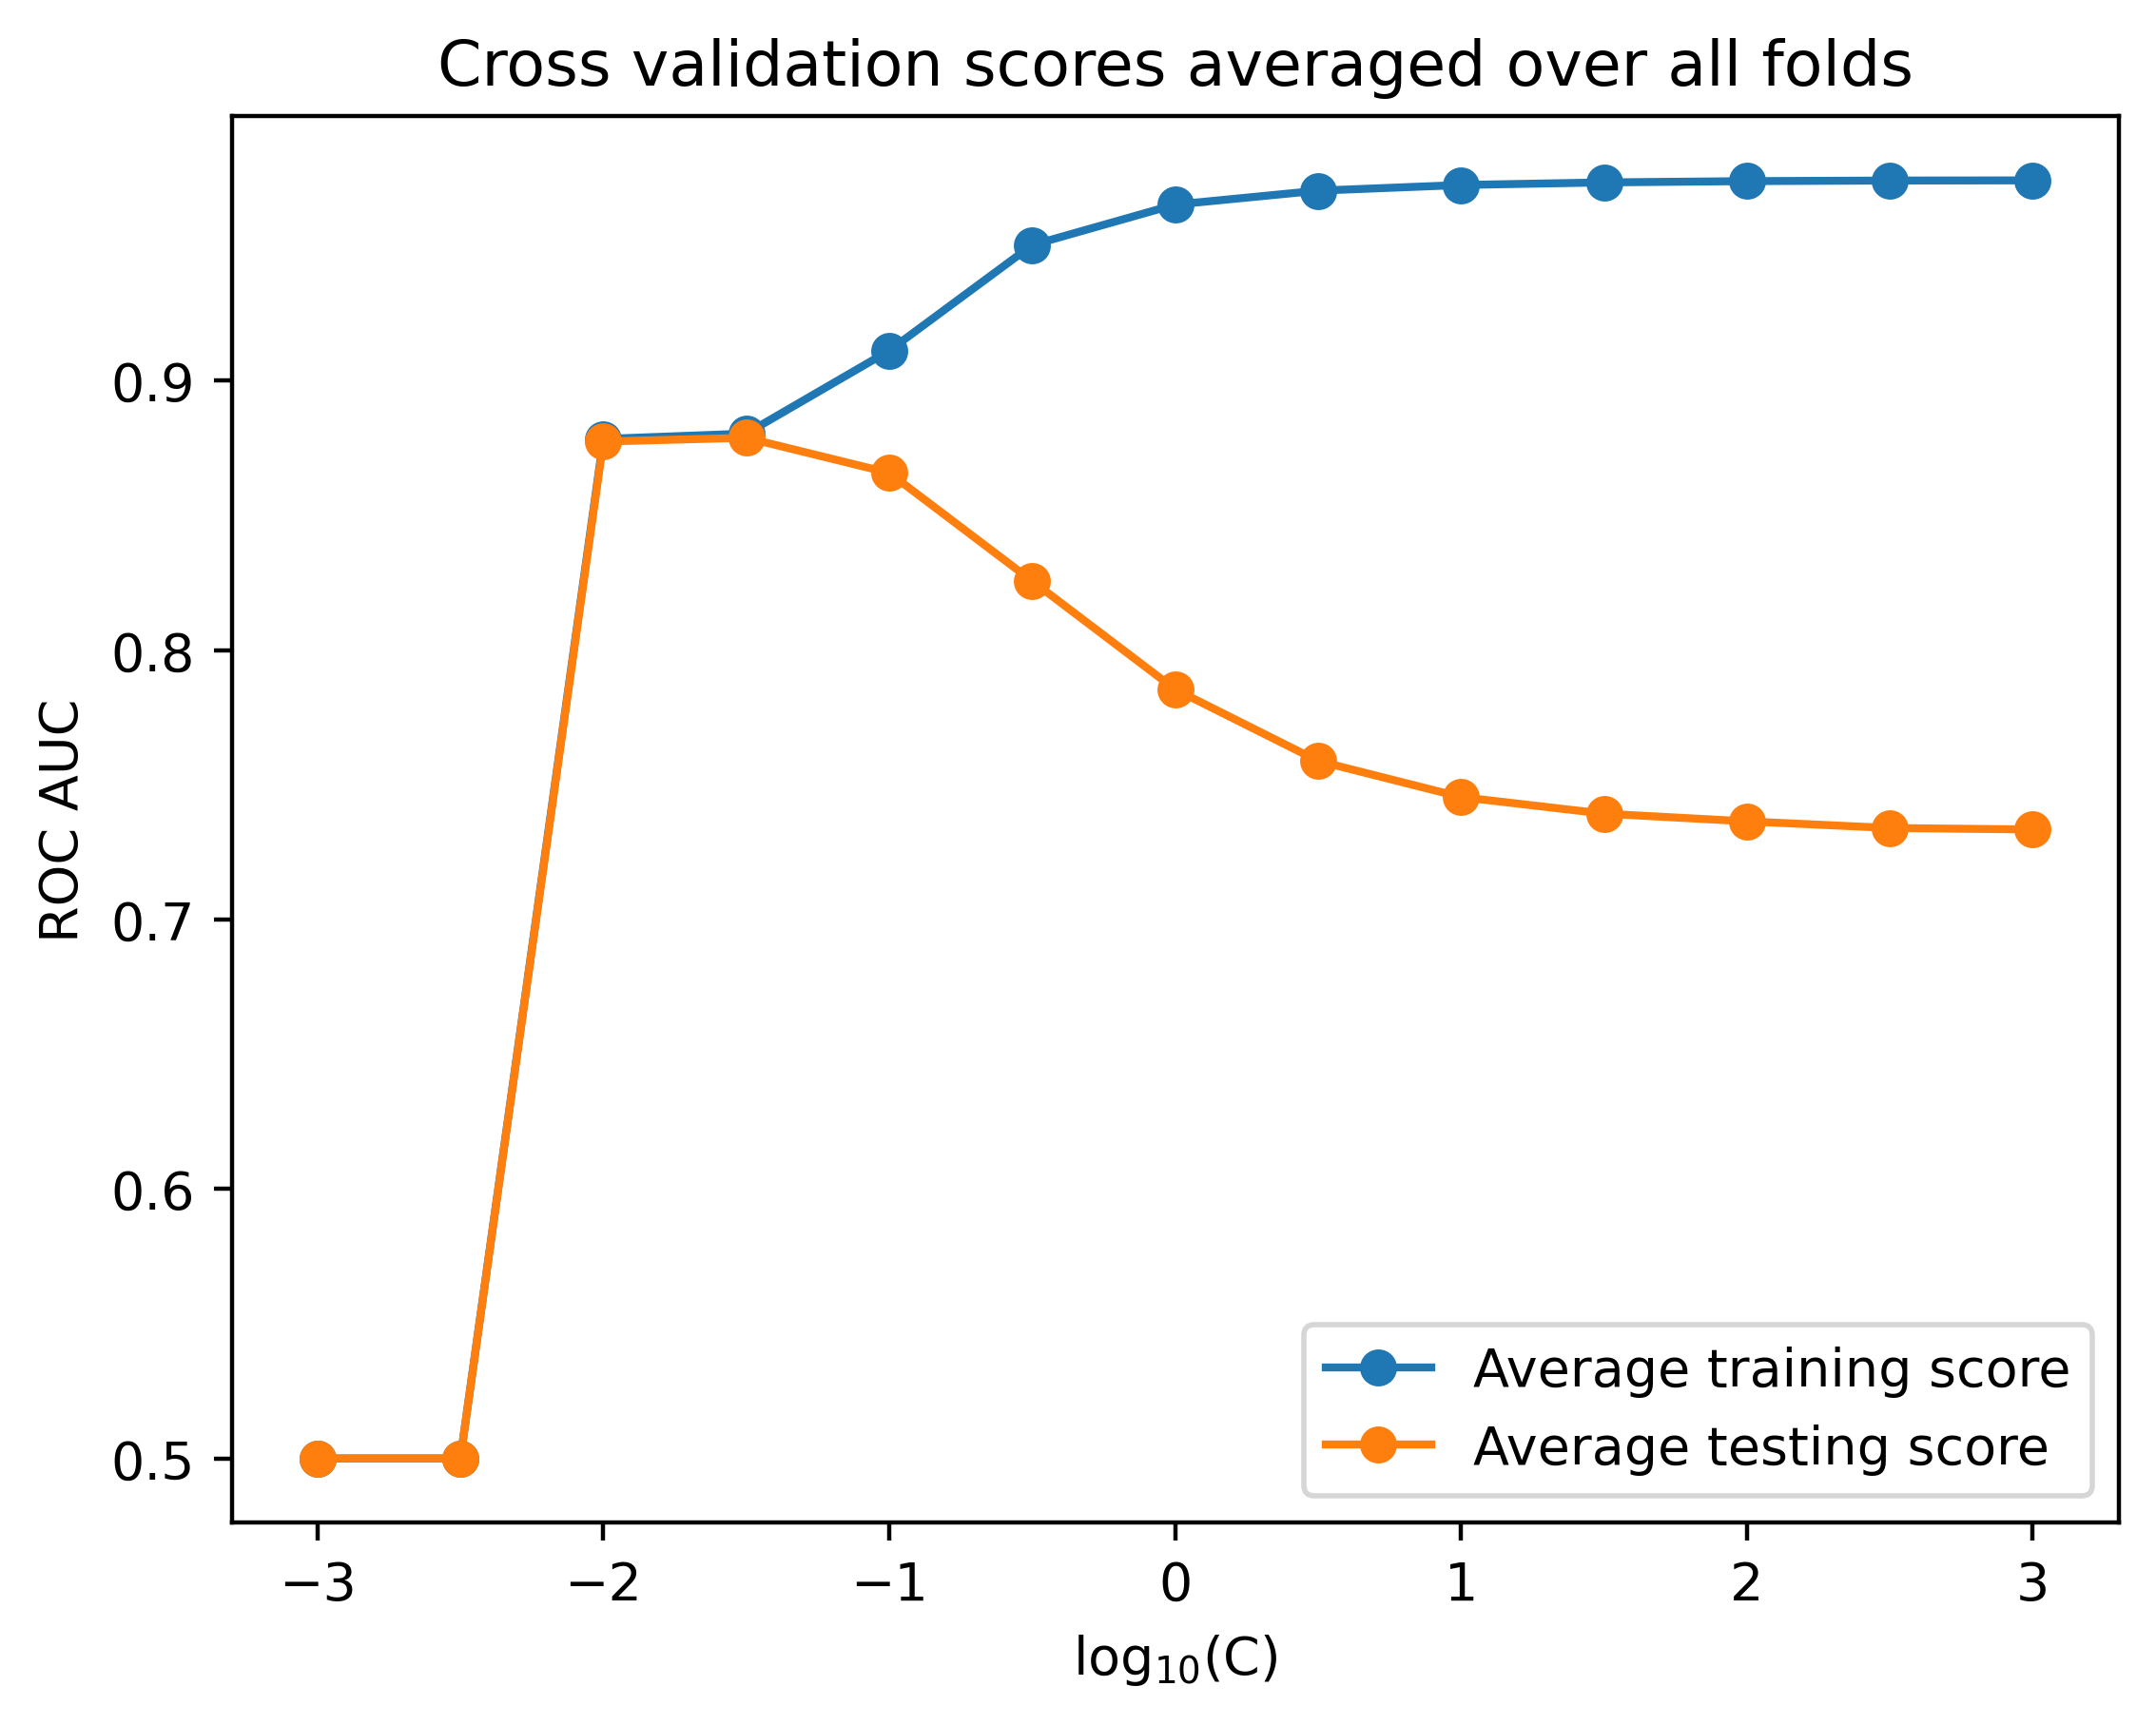

In [57]:
plt.plot(c_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label="Average training score")
plt.plot(c_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-o',
        label="Average testing score")
plt.ylabel("ROC AUC")
plt.xlabel("log$_{10}$(C)")
plt.legend()
plt.title("Cross validation scores averaged over all folds")

In [64]:
# the best values for C are C**(-1.5) to C**(-2.1)
best_c_val_bool = c_val_exponents == -1.5
best_c_val_bool.astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [65]:
best_c_val_ix = np.nonzero(best_c_val_bool.astype(int))
best_c_val_ix[0][0]

9

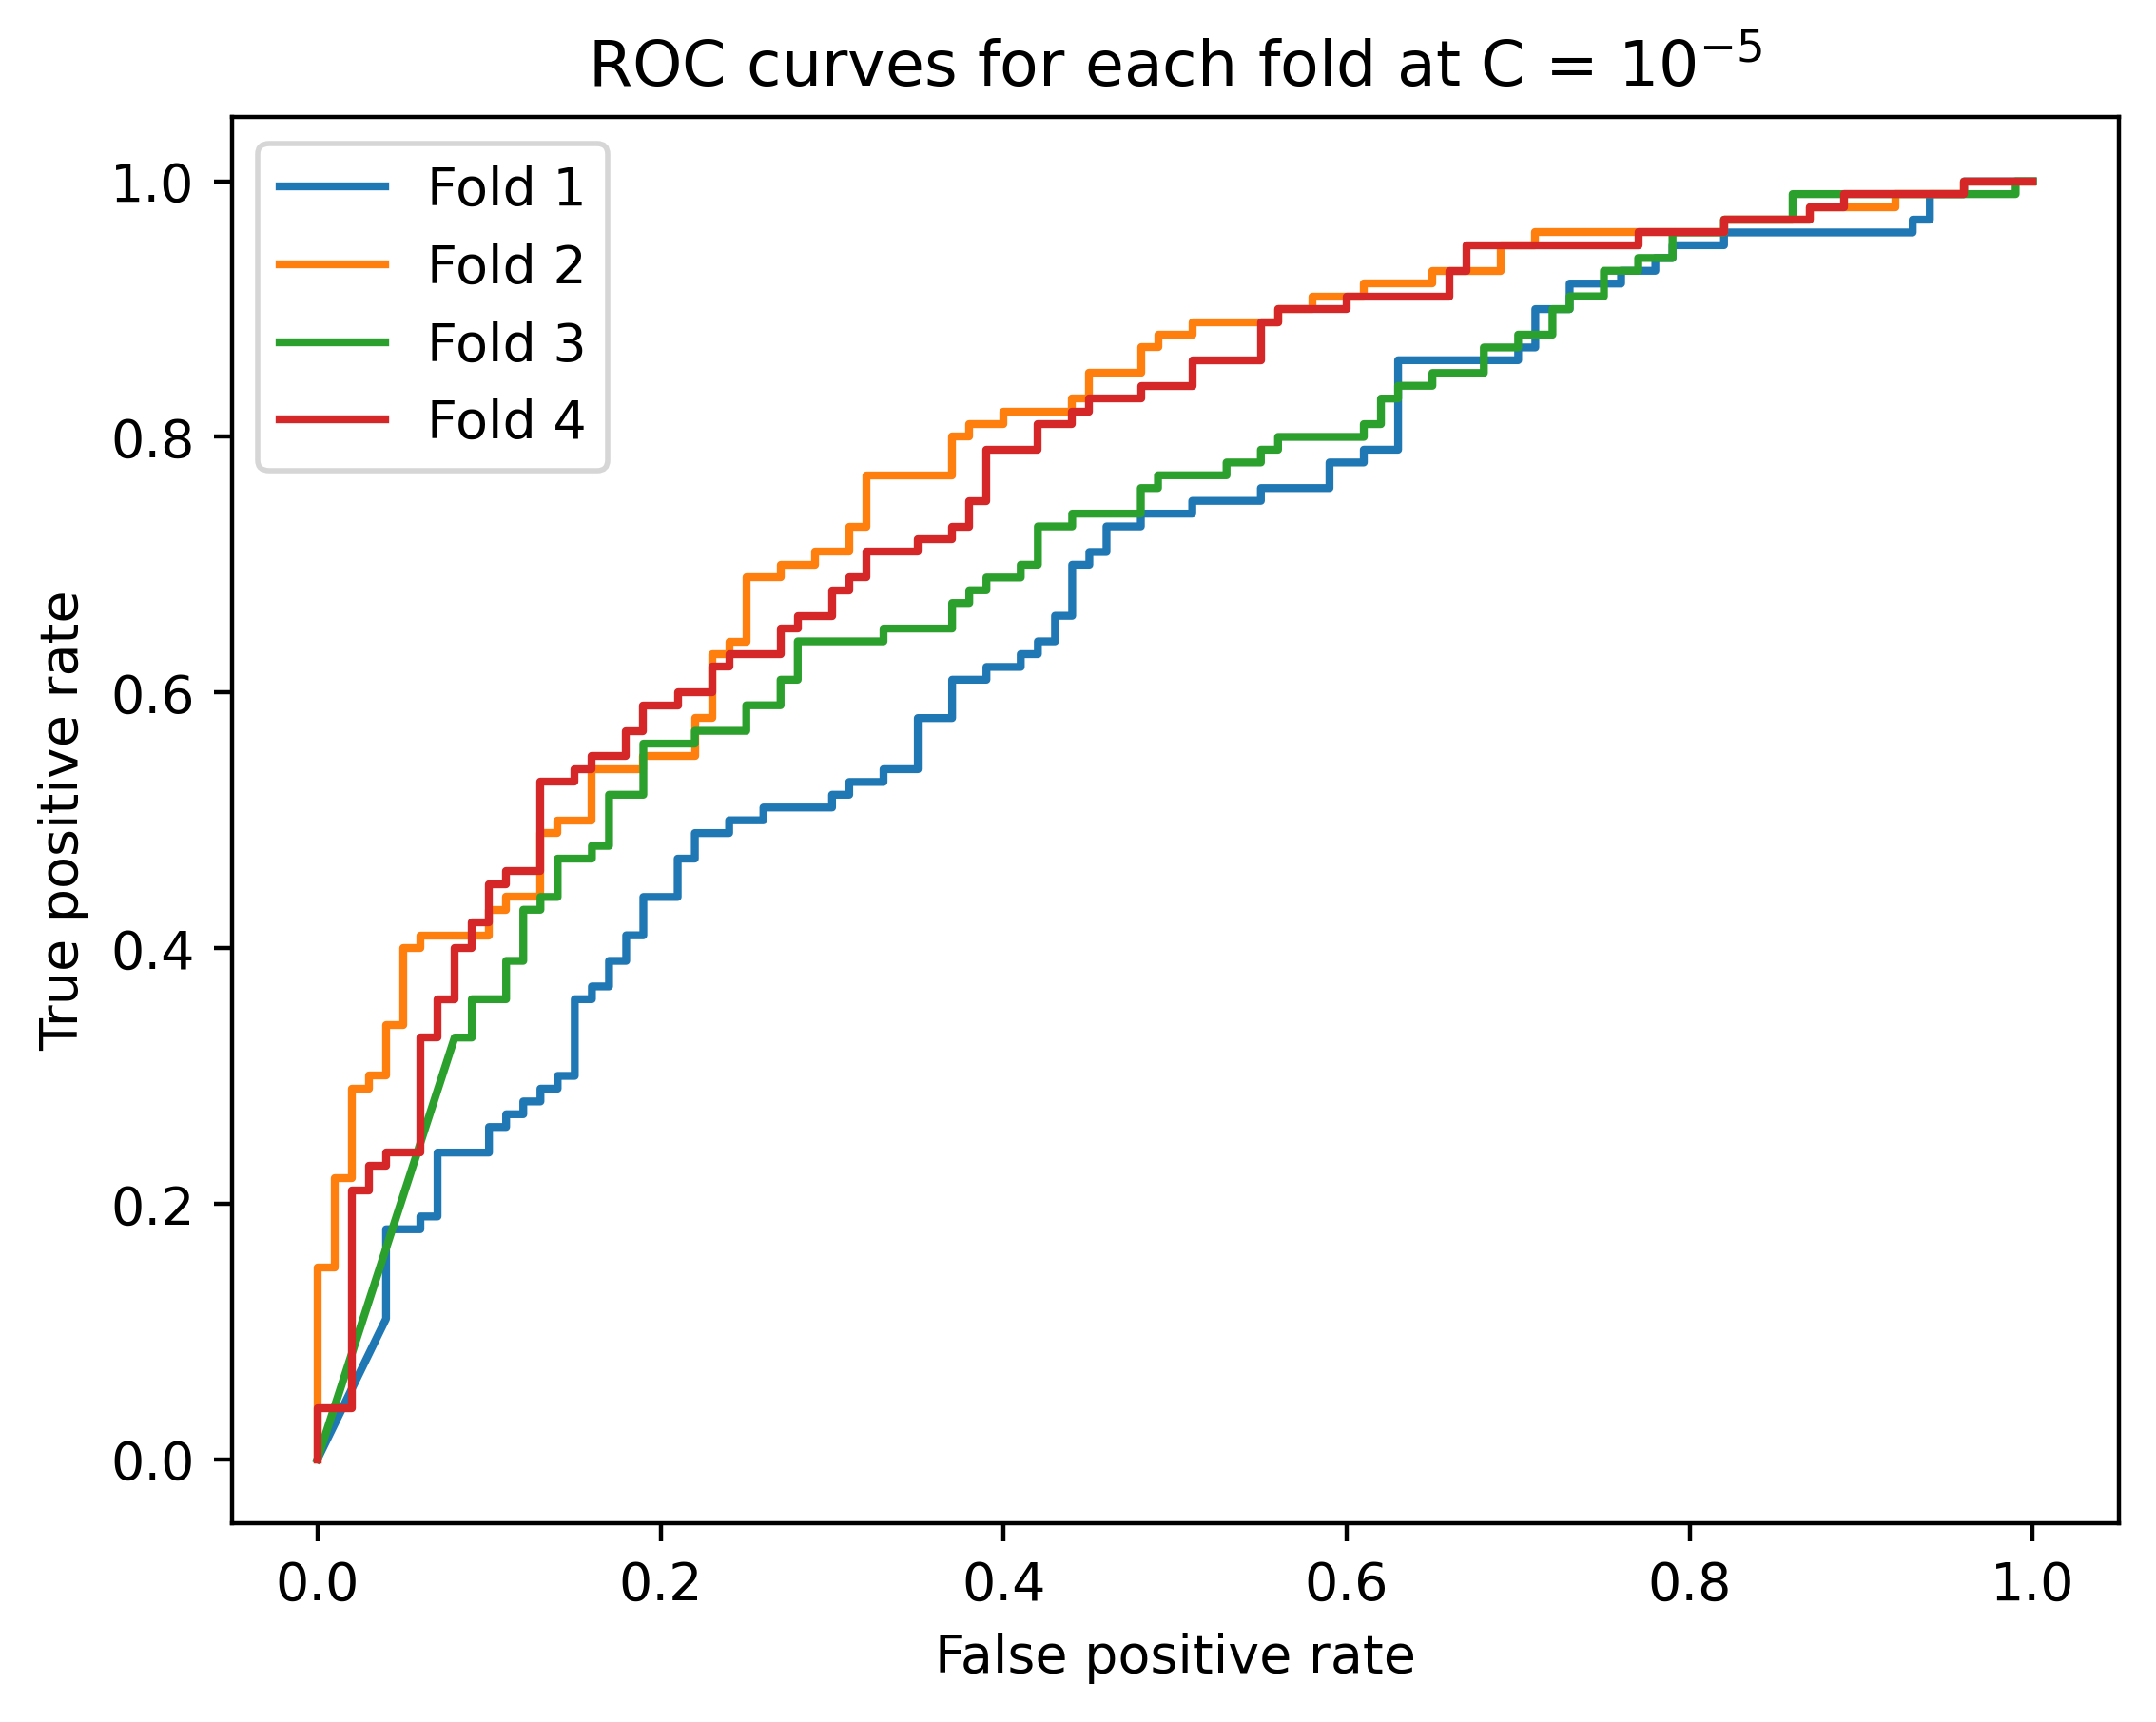

In [66]:
for this_fold in range(n_folds):
    fpr = cv_test_roc[best_c_val_ix[0][0]][this_fold][0]
    tpr = cv_test_roc[best_c_val_ix[0][0]][this_fold][1]
    plt.plot(fpr, tpr, label="Fold {}".format(this_fold+1))

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curves for each fold at C = $10^{-5}$")
plt.legend()

It can be seen that there is some variability in the curves, which can indicate that it would be good to add some data. Usually, the larger the training data available, the smaller the variability is.

In [67]:
lr_syn.C = 10**(-1.5)
lr_syn.fit(x_syn_train, y_syn_train)

LogisticRegression(C=0.03162277660168379, penalty='l1', random_state=1,
                   solver='liblinear')

In [68]:
y_syn_train_predict_proba = lr_syn.predict_proba(x_syn_train)
roc_auc_score(y_syn_train, y_syn_train_predict_proba[:, 1])

0.8802812499999999

In [72]:
y_syn_test_predict_proba = lr_syn.predict_proba(x_syn_test)
roc_auc_score(y_syn_test, y_syn_test_predict_proba[:, 1])

0.8847884788478848

From the comparison above, it can be seen that the overfitting problem has been solved, once the train and test predicting AUC score are very similar.
After that, verify the coeficients of the model to check how many of them were reduced to zero.

In [73]:
# verify how many ARE NOT zero
sum((lr_syn.coef_ != 0)[0])

2

In [74]:
# in this cell it can be seen that the interception was regularized with 0
lr_syn.intercept_

array([0.])